<a href="https://colab.research.google.com/github/qurit-frizi/3D-U-Net/blob/main/17MAY_lesion_size_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Install necessary packages ---
# !pip install SimpleITK radiomics networkx scikit-image
# Install SimpleITK
!pip install SimpleITK

# Install other necessary libraries
!pip install numpy scipy networkx scikit-image opencv-python matplotlib pyradiomics pandas itk-elastix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 13.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 51.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8

In [ ]:
cd /content/drive/MyDrive/spect/HTK_SNMMI2025/

/content/drive/MyDrive/spect/HTK_SNMMI2025


In [ ]:
import os
import numpy as np
import SimpleITK as sitk
import pandas as pd

def compute_lesion_volumes_single_patient(base_path, patient_id="Unknown"):
    timepoints = sorted(os.listdir(base_path))
    volume_data = []

    for timepoint in timepoints:
        lesion_dir = os.path.join(base_path, timepoint, 'lesions')
        if not os.path.isdir(lesion_dir):
            continue

        for lesion_file in os.listdir(lesion_dir):
            if lesion_file.endswith(".nii") or lesion_file.endswith(".nii.gz"):
                lesion_path = os.path.join(lesion_dir, lesion_file)
                image = sitk.ReadImage(lesion_path)
                array = sitk.GetArrayFromImage(image)
                voxel_volume = np.prod(image.GetSpacing())  # mm^3 4.7501 × 4.8920 × 4.7420 ≈ 110.32 mm³
                lesion_volume = (array > 0).sum() * voxel_volume

                volume_data.append({
                    'PatientID': patient_id,
                    'Timepoint': timepoint,
                    'LesionID': lesion_file.replace('.nii.gz', '').replace('.nii', ''),
                    'Volume_mm3': lesion_volume
                })

    df = pd.DataFrame(volume_data)
    df.sort_values(by=['LesionID', 'Timepoint'], inplace=True)
    df['VolumeChange_%'] = df.groupby('LesionID')['Volume_mm3'].pct_change() * 100
    return df

# Example usage
base_path = "08"  # or full path if you're not running in the right folder
lesion_volume_df = compute_lesion_volumes_single_patient(base_path, patient_id="O4")

# Save if needed
lesion_volume_df.to_csv("lesion_volumes_08.csv", index=False)

lesion_volume_df.head()



,PatientID,Timepoint,LesionID,Volume_mm3,VolumeChange_%
28,O4,2024-08-24,Lesion_(1)_#1.uint16,63801.502983,NaN
165,O4,2024-10-26,Lesion_(1)_#1.uint16,58291.874055,-8.635579
161,O4,2024-08-31,Lesion_(1)_#39.uint16,63581.117826,NaN
40,O4,2024-08-24,Lesion_(10)_#10.uint16,19283.701247,NaN
204,O4,2024-10-26,Lesion_(10)_#10.uint16,22589.478604,17.142857


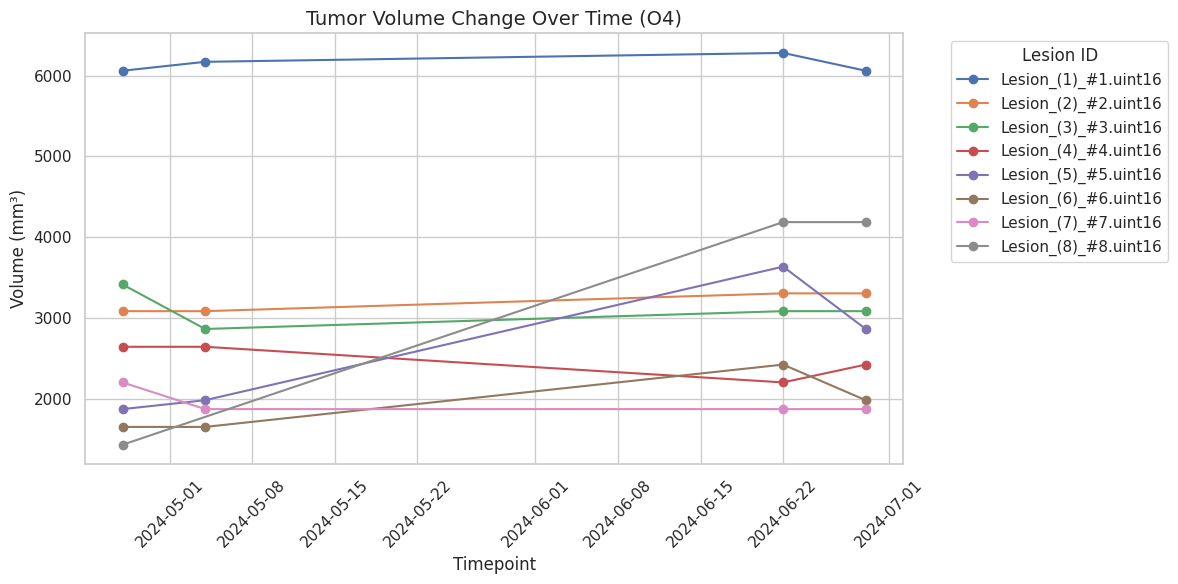

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Load your CSV (or use the DataFrame directly)
# df = pd.read_csv("lesion_volumes_O4.csv")  # or use your DataFrame

# # Ensure Timepoint is treated as a date
# df['Timepoint'] = pd.to_datetime(df['Timepoint'])

# # Sort by lesion and time
# df = df.sort_values(by=['LesionID', 'Timepoint'])

# # Plot
# plt.figure(figsize=(12, 6))
# sns.set(style="whitegrid")

# for lesion_id, group in df.groupby("LesionID"):
#     plt.plot(group["Timepoint"], group["Volume_mm3"], marker='o', label=lesion_id)

# plt.title("Tumor Volume Change Over Time (O4)", fontsize=14)
# plt.xlabel("Timepoint", fontsize=12)
# plt.ylabel("Volume (mm³)", fontsize=12)
# plt.xticks(rotation=45)
# plt.legend(title="Lesion ID", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()



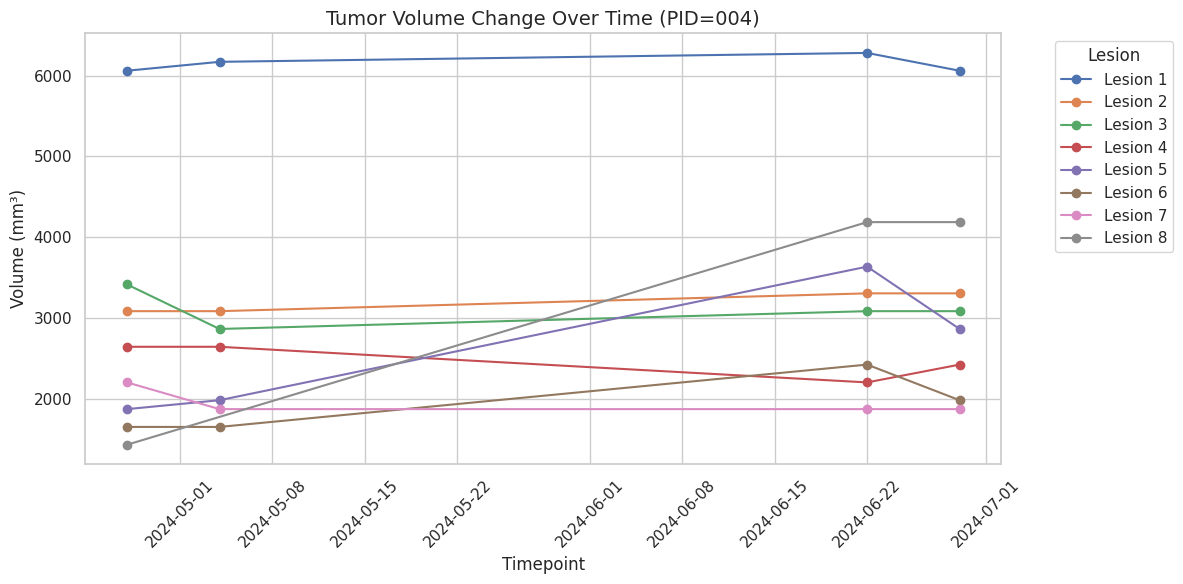

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import re

# # Load your data
# df = pd.read_csv("lesion_volumes_O4.csv")
# df['Timepoint'] = pd.to_datetime(df['Timepoint'])

# # Extract simplified lesion labels like "Lesion 1"
# pattern = re.compile(r"\((\d+)\)")
# df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(x).group(1)}")

# # Plot
# plt.figure(figsize=(12, 6))
# sns.set(style="whitegrid")

# for lesion_label, group in df.groupby("LesionLabel"):
#     plt.plot(group["Timepoint"], group["Volume_mm3"], marker='o', label=lesion_label)

# plt.title("Tumor Volume Change Over Time (PID=004)", fontsize=14)
# plt.xlabel("Timepoint", fontsize=12)
# plt.ylabel("Volume (mm³)", fontsize=12)
# plt.xticks(rotation=45)
# plt.legend(title="Lesion", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()



<ipython-input-6-331ed17a1a63>:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


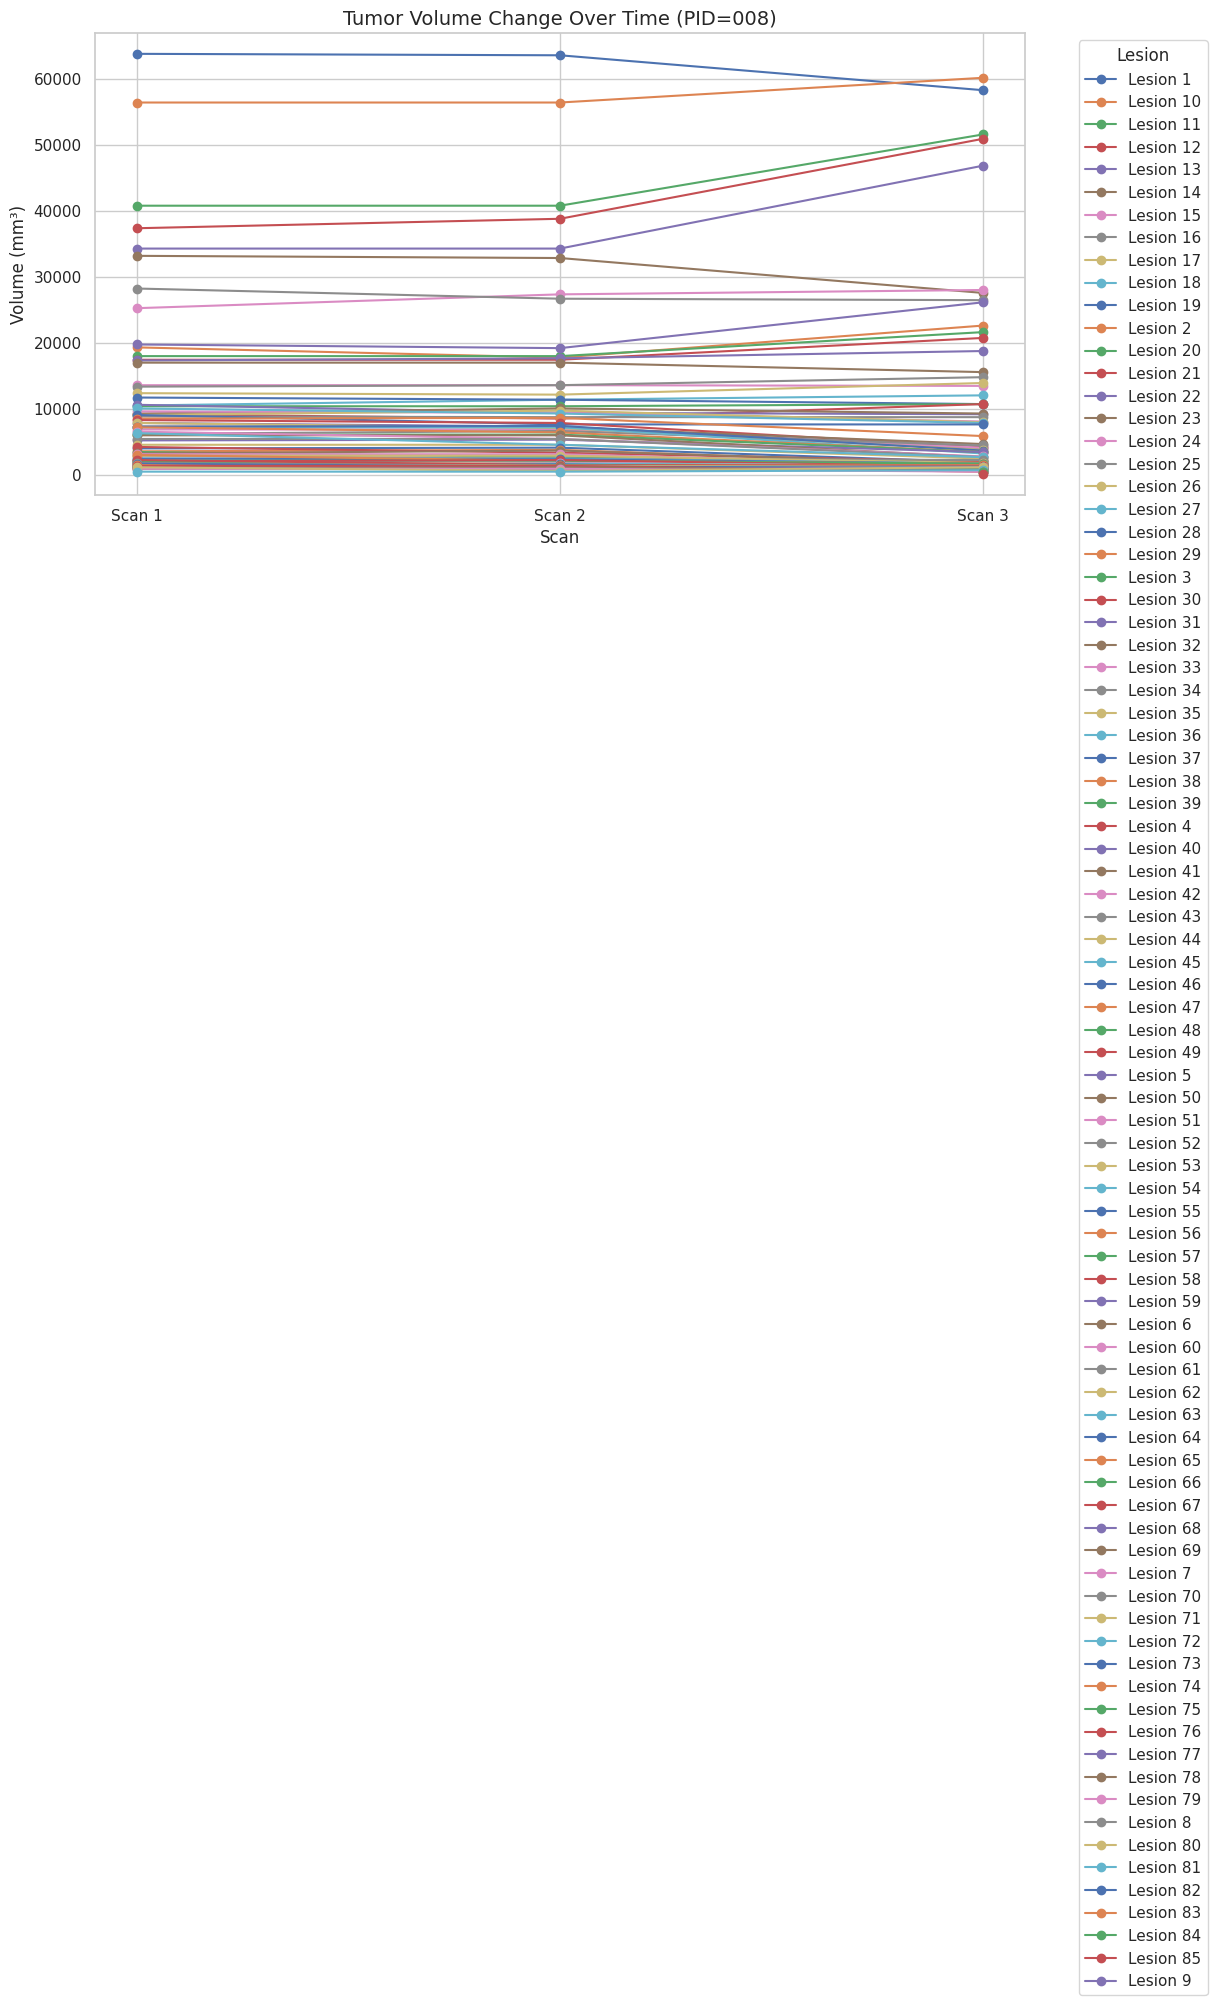

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load your data
df = pd.read_csv("lesion_volumes_08.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])

# Extract simplified lesion labels like "Lesion 1"
pattern = re.compile(r"\((\d+)\)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(x).group(1)}")

# Map unique timepoints to Scan 1, Scan 2, etc.
timepoint_order = {tp: f"Scan {i+1}" for i, tp in enumerate(sorted(df['Timepoint'].unique()))}
df['ScanLabel'] = df['Timepoint'].map(timepoint_order)

# Sort dataframe for plotting order
df = df.sort_values(['LesionLabel', 'Timepoint'])

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

for lesion_label, group in df.groupby("LesionLabel"):
    plt.plot(group["ScanLabel"], group["Volume_mm3"], marker='o', label=lesion_label)

plt.title("Tumor Volume Change Over Time (PID=008)", fontsize=14)
plt.xlabel("Scan", fontsize=12)
plt.ylabel("Volume (mm³)", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Lesion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<ipython-input-56-747b3a41b57b>:45: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



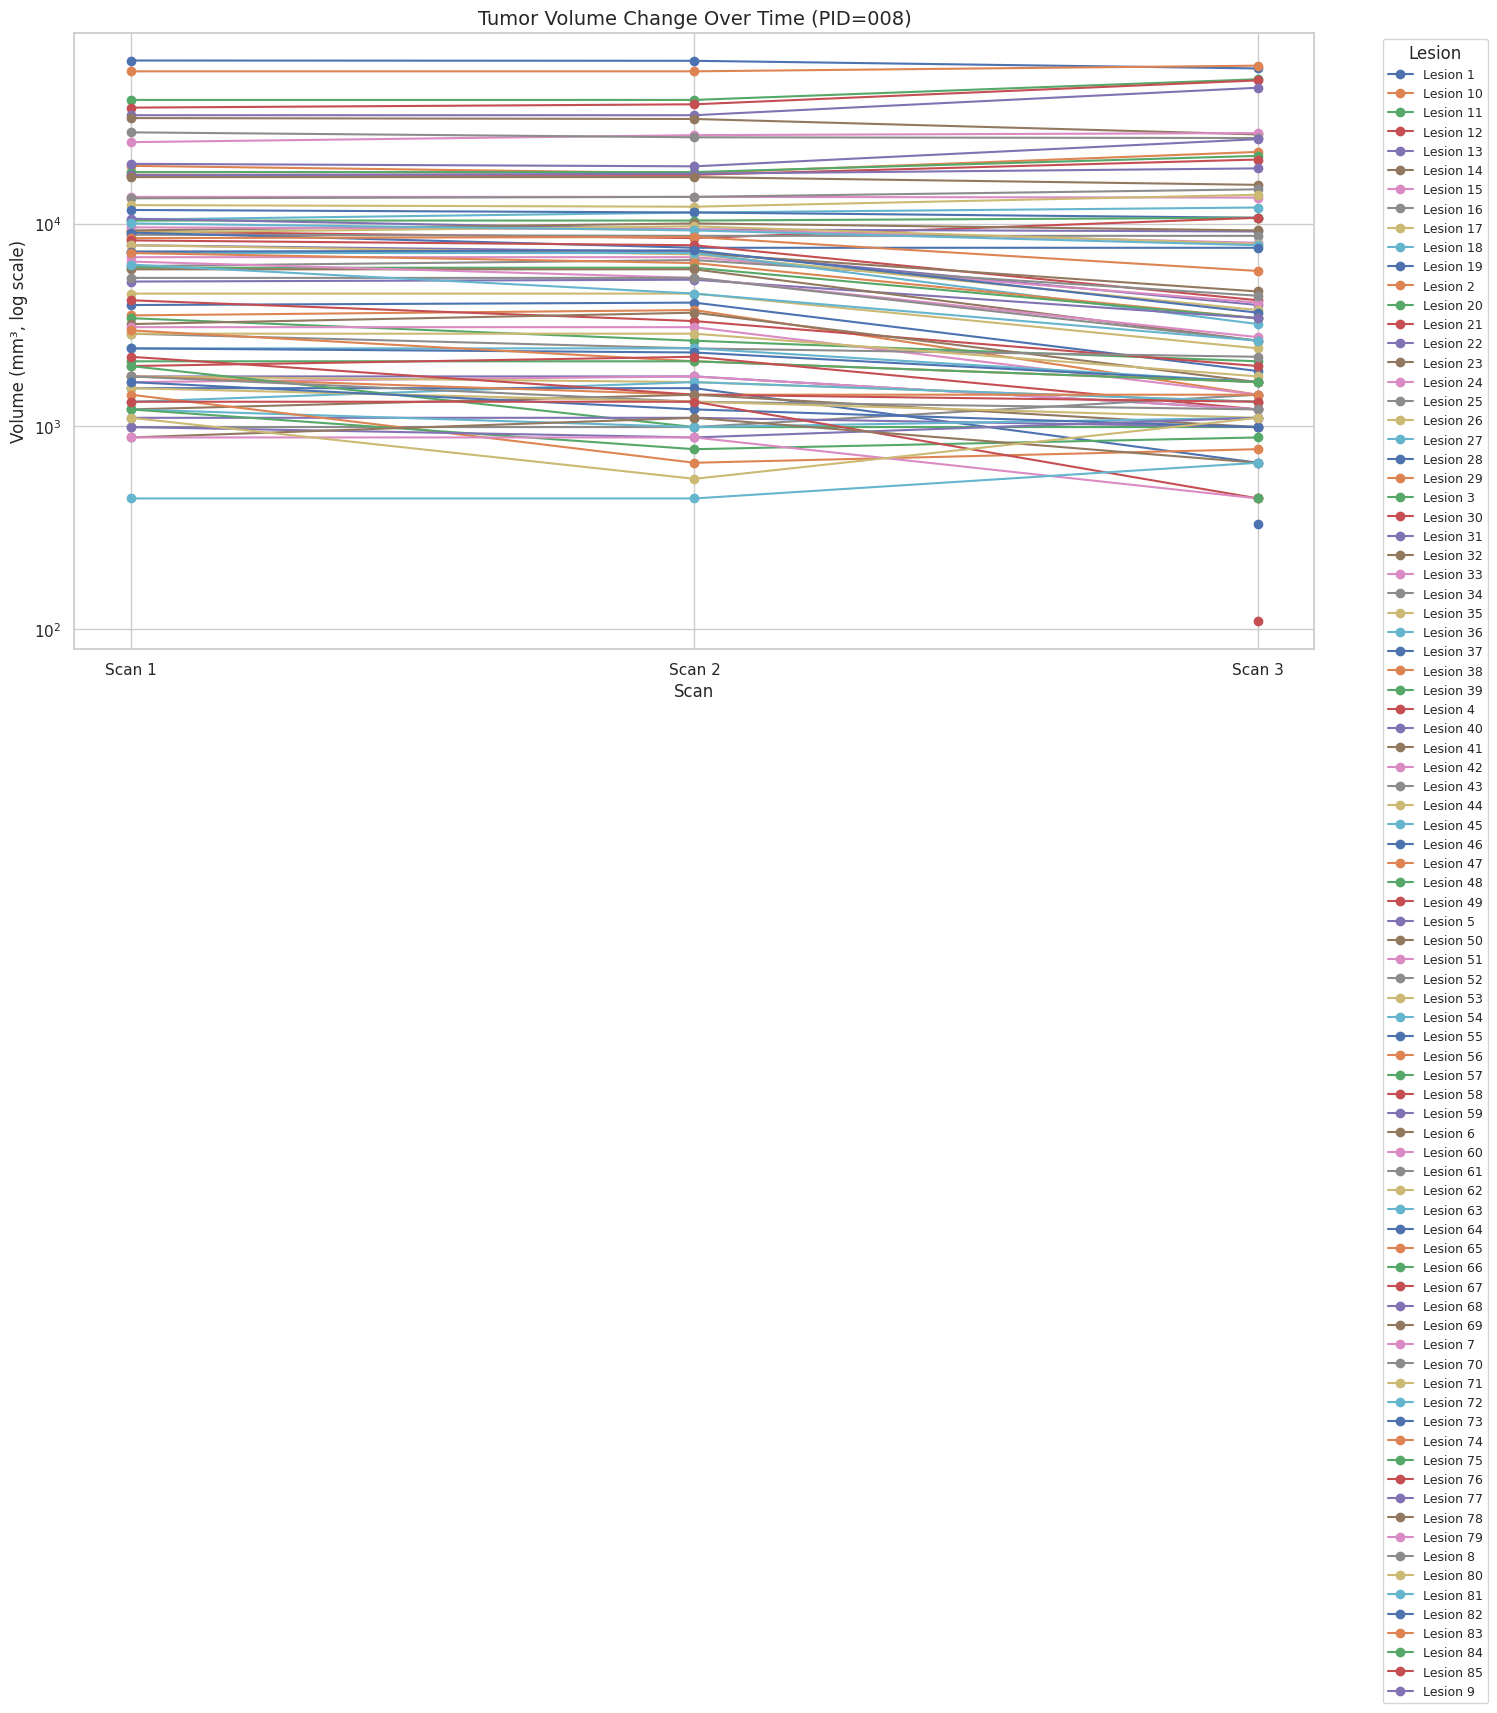

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load your data
df = pd.read_csv("lesion_volumes_08.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])

# Try to extract a number for each lesion, fallback to unique integer if not possible
pattern = re.compile(r"\((\d+)\)")
unique_lesions = {}
def extract_lesion_label(x):
    match = pattern.search(str(x))
    if match:
        label = f"Lesion {match.group(1)}"
    else:
        if x not in unique_lesions:
            unique_lesions[x] = f"Lesion X{len(unique_lesions)+1}"
        label = unique_lesions[x]
    return label

df['LesionLabel'] = df['LesionID'].apply(extract_lesion_label)

# Map timepoints to Scan 1, Scan 2, etc.
unique_timepoints = sorted(df['Timepoint'].unique())
timepoint_order = {tp: f"Scan {i+1}" for i, tp in enumerate(unique_timepoints)}
df['ScanLabel'] = df['Timepoint'].map(timepoint_order)

df = df.sort_values(['LesionLabel', 'Timepoint'])

# Plot
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")

for lesion_label, group in df.groupby("LesionLabel"):
    plt.plot(group["ScanLabel"], group["Volume_mm3"], marker='o', label=lesion_label)

plt.title("Tumor Volume Change Over Time (PID=008)", fontsize=14)
plt.xlabel("Scan", fontsize=12)
plt.ylabel("Volume (mm³, log scale)", fontsize=12)
plt.yscale('log')
plt.xticks(rotation=0)
plt.legend(title="Lesion", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()



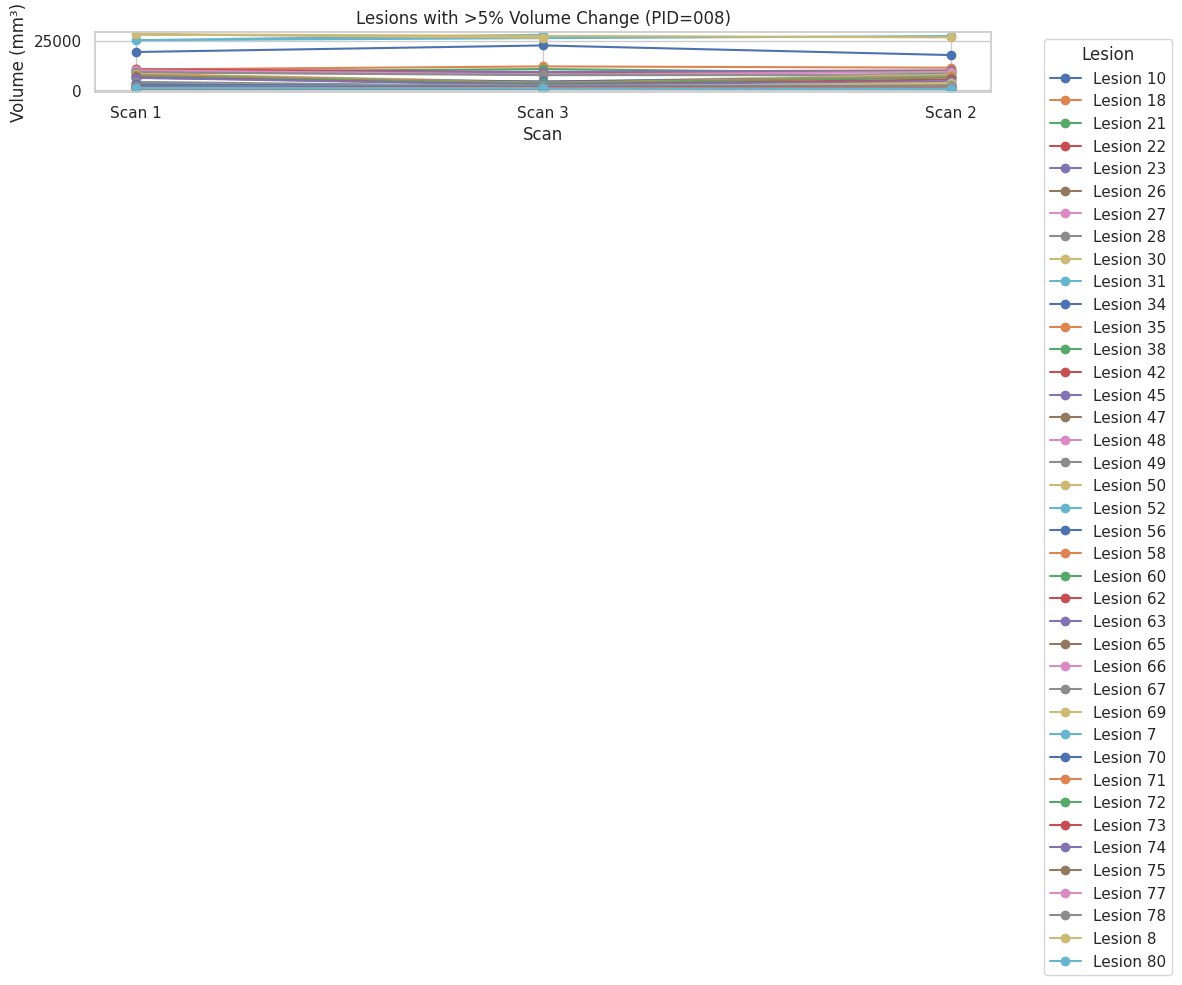

In [ ]:
import pandas as pd

# Load your data
df = pd.read_csv("lesion_volumes_08.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])

# Fix lesion labeling (more permissive)
import re
pattern = re.compile(r"(\d+)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(str(x)).group(1)}" if pattern.search(str(x)) else str(x))

# Map timepoints to Scan labels
unique_timepoints = sorted(df['Timepoint'].unique())
timepoint_order = {tp: f"Scan {i+1}" for i, tp in enumerate(unique_timepoints)}
df['ScanLabel'] = df['Timepoint'].map(timepoint_order)

# Compute volume change
pivot = df.pivot(index='LesionLabel', columns='ScanLabel', values='Volume_mm3')
pivot['AbsChange'] = (pivot['Scan 2'] - pivot['Scan 1']).abs()
pivot['PercentChange'] = 100 * (pivot['Scan 2'] - pivot['Scan 1']) / pivot['Scan 1']

# Show only lesions with >5% change
changing_lesions = pivot[pivot['PercentChange'].abs() > 5].index.tolist()
df_changing = df[df['LesionLabel'].isin(changing_lesions)]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
for lesion_label, group in df_changing.groupby("LesionLabel"):
    plt.plot(group["ScanLabel"], group["Volume_mm3"], marker='o', label=lesion_label)

plt.title("Lesions with >5% Volume Change (PID=008)")
plt.xlabel("Scan")
plt.ylabel("Volume (mm³)")
plt.legend(title="Lesion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


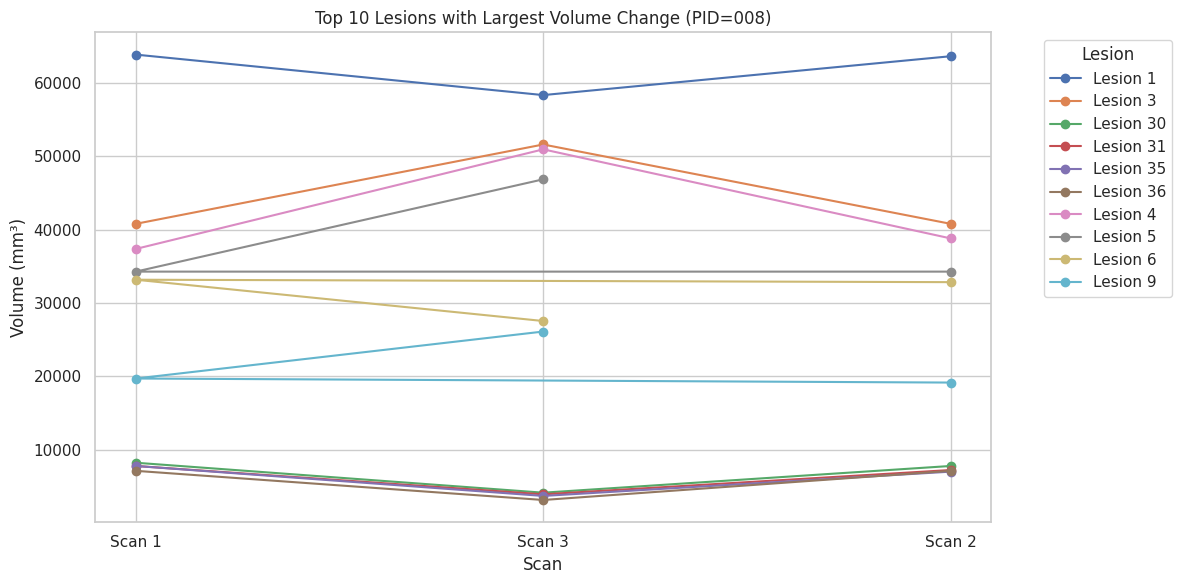

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load your data
df = pd.read_csv("lesion_volumes_08.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])

# Fix lesion labeling (broadly)
pattern = re.compile(r"(\d+)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(str(x)).group(1)}" if pattern.search(str(x)) else str(x))

# Map timepoints to Scan labels
unique_timepoints = sorted(df['Timepoint'].unique())
timepoint_order = {tp: f"Scan {i+1}" for i, tp in enumerate(unique_timepoints)}
df['ScanLabel'] = df['Timepoint'].map(timepoint_order)

# Fix scan order
scan_categories = sorted(df['ScanLabel'].unique(), key=lambda x: int(x.split()[1]))
df['ScanLabel'] = pd.Categorical(df['ScanLabel'], categories=scan_categories, ordered=True)

# Compute change
pivot = df.pivot(index='LesionLabel', columns='ScanLabel', values='Volume_mm3')
pivot['AbsChange'] = pivot[scan_categories[-1]] - pivot[scan_categories[0]]
pivot['PercentChange'] = 100 * (pivot[scan_categories[-1]] - pivot[scan_categories[0]]) / pivot[scan_categories[0]]

# Plot only top 10 changing lesions
top_lesions = pivot['AbsChange'].abs().sort_values(ascending=False).head(10).index
df_top = df[df['LesionLabel'].isin(top_lesions)]

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
for lesion_label, group in df_top.groupby("LesionLabel"):
    plt.plot(group["ScanLabel"], group["Volume_mm3"], marker='o', label=lesion_label)

plt.title("Top 10 Lesions with Largest Volume Change (PID=008)")
plt.xlabel("Scan")
plt.ylabel("Volume (mm³)")
plt.legend(title="Lesion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import SimpleITK as sitk

img = sitk.ReadImage("04/2024-04-27/spect/spect.nii.gz")
print("Voxel spacing (mm):", img.GetSpacing())

Voxel spacing (mm): (4.750142574310303, 4.891972541809082, 4.742001533508301)


In [ ]:
lesion_mask = sitk.ReadImage("04/2024-04-27/lesions/Lesion_(2)_#2.uint16.nii.gz")
print("Lesion mask spacing:", lesion_mask.GetSpacing())

Lesion mask spacing: (4.750142574310303, 4.891972541809082, 4.742001533508301)


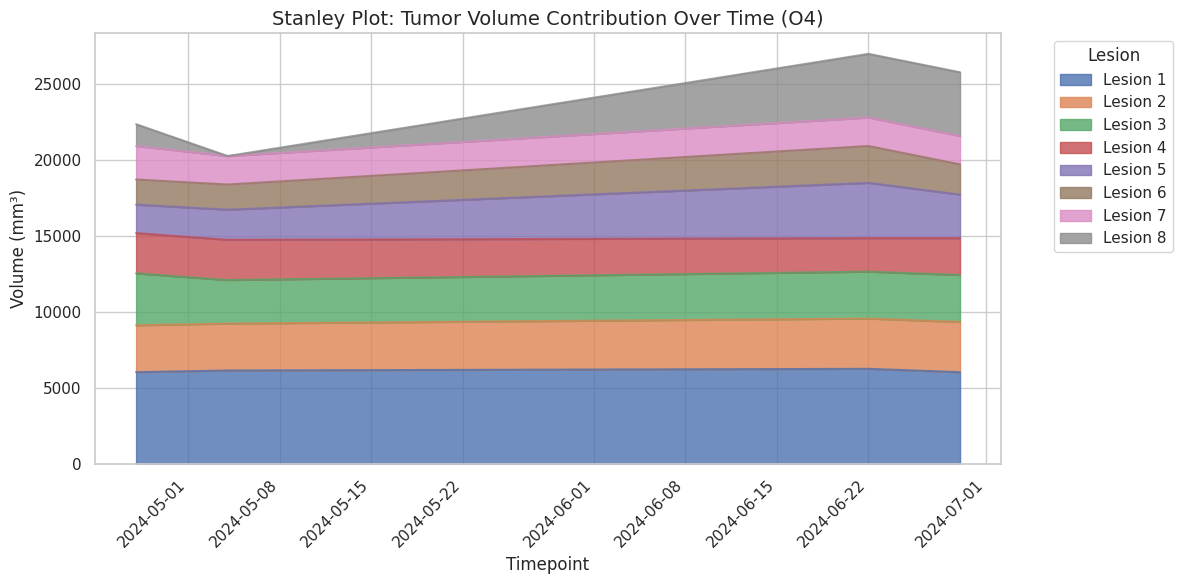

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load data
df = pd.read_csv("lesion_volumes_O4.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])

# Extract simplified lesion labels
pattern = re.compile(r"\((\d+)\)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(x).group(1)}")

# Pivot to wide format: rows = timepoints, columns = lesions
pivot_df = df.pivot(index='Timepoint', columns='LesionLabel', values='Volume_mm3')

# Sort timepoints
pivot_df = pivot_df.sort_index()

# Fill missing values with 0 or forward-fill if you prefer
pivot_df = pivot_df.fillna(0)

# Plot: Stanley (stacked area)
pivot_df.plot.area(figsize=(12, 6), alpha=0.8)

plt.title("Stanley Plot: Tumor Volume Contribution Over Time (O4)", fontsize=14)
plt.xlabel("Timepoint", fontsize=12)
plt.ylabel("Volume (mm³)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Lesion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
pip install plotly kaleido pandas


In [ ]:
import pandas as pd
import re

# Load your CSV file
#df = pd.read_csv("lesion_volumes_O8.csv")  # Adjust path if needed
df = pd.read_csv("lesion_volumes_08.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])
df['TimepointStr'] = df['Timepoint'].dt.strftime('%Y-%m-%d')

# Extract simplified lesion labels like "Lesion 1"
pattern = re.compile(r"\((\d+)\)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(x).group(1)}")

# Sort and compute % change in volume
df = df.sort_values(by=['LesionLabel', 'Timepoint'])
df['VolumeChange'] = df.groupby('LesionLabel')['Volume_mm3'].pct_change()

# Classify lesion response based on % change
def classify_response(change):
    if pd.isna(change):
        return 'Baseline'
    elif change >= 0.2:
        return 'Increasing'
    elif change <= -0.2:
        return 'Decreasing'
    elif -0.05 <= change <= 0.05:
        return 'Stable'
    else:
        return 'Fluctuating'

df['ResponseType'] = df['VolumeChange'].apply(classify_response)

# Build a transitions table for Sankey or network plotting
transitions = []
for lesion, group in df.groupby('LesionLabel'):
    group = group.sort_values("Timepoint")
    for i in range(len(group) - 1):
        source = f"{group.iloc[i]['LesionLabel']} @ {group.iloc[i]['TimepointStr']}"
        target = f"{group.iloc[i+1]['LesionLabel']} @ {group.iloc[i+1]['TimepointStr']}"
        response = group.iloc[i+1]['ResponseType']
        volume = group.iloc[i+1]['Volume_mm3']
        transitions.append({
            'source': source,
            'target': target,
            'response': response,
            'volume': volume
        })

# Create DataFrame of transitions
transition_df = pd.DataFrame(transitions)

# Save for Sankey plotting or review
transition_df.to_csv("lesion_volume_transitions_08.csv", index=False)
print("Saved: lesion_volume_transitions_08.csv")


Saved: lesion_volume_transitions_08.csv


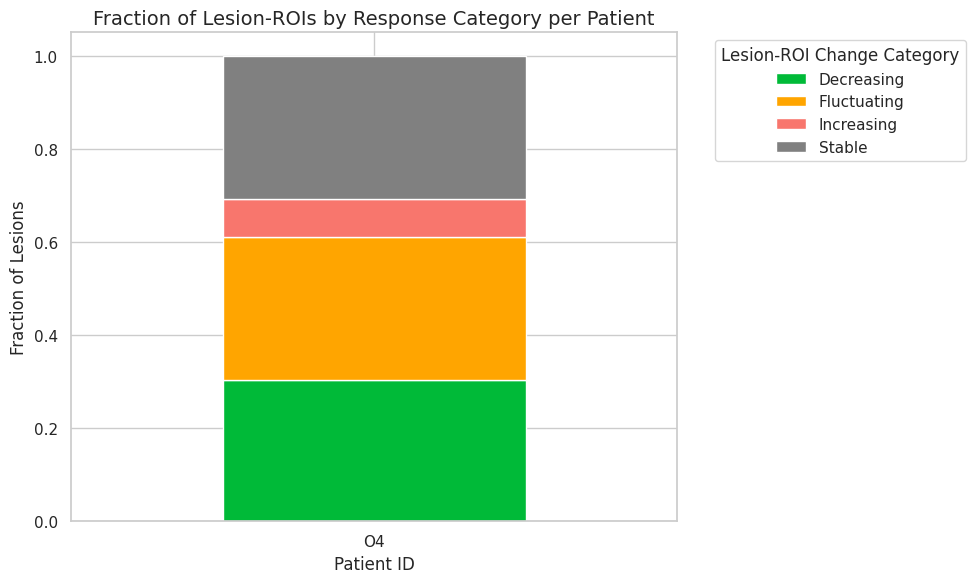

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# === Load Data ===
#df = pd.read_csv("lesion_volumes_O8.csv")  # Replace with your actual path
df = pd.read_csv("lesion_volumes_08.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])
df['TimepointStr'] = df['Timepoint'].dt.strftime('%Y-%m-%d')

# === Extract Simplified Lesion Labels ===
pattern = re.compile(r"\((\d+)\)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(x).group(1)}")

# === Sort and Compute Volume Change per Lesion ===
df = df.sort_values(by=['LesionLabel', 'Timepoint'])
df['VolumeChange'] = df.groupby('LesionLabel')['Volume_mm3'].pct_change()

# === Classify Lesion Response ===
def classify_response(change, volume):
    if pd.isna(change):
        return 'Baseline'
    elif volume == 0:
        return 'Disappearing'
    elif change >= 0.2:
        return 'Increasing'
    elif change <= -0.2:
        return 'Decreasing'
    elif -0.05 <= change <= 0.05:
        return 'Stable'
    else:
        return 'Fluctuating'

df['ResponseType'] = df.apply(lambda x: classify_response(x['VolumeChange'], x['Volume_mm3']), axis=1)

# === Filter Out Baseline (not relevant for stacked chart) ===
df_filtered = df[df['ResponseType'] != 'Baseline']

# === Count and Normalize by Patient ===
response_counts = df_filtered.groupby(['PatientID', 'ResponseType'])['LesionID'].count().unstack().fillna(0)
response_fractions = response_counts.div(response_counts.sum(axis=1), axis=0)

# === Plot ===
color_map = {
    'New': 'red',
    'Increasing': '#f8766d',
    'Stable': 'gray',
    'Decreasing': '#00ba38',
    'Disappearing': '#00ff00',
    'Fluctuating': 'orange'
}

ax = response_fractions.plot(kind='bar', stacked=True, figsize=(10, 6), color=color_map)
plt.title("Fraction of Lesion-ROIs by Response Category per Patient", fontsize=14)
plt.ylabel("Fraction of Lesions")
plt.xlabel("Patient ID")
plt.xticks(rotation=0)
plt.legend(title="Lesion-ROI Change Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("lesion_response_distribution.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd
import re

# Load your CSV
df = pd.read_csv("lesion_volumes_O4.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])
df['TimepointStr'] = df['Timepoint'].dt.strftime('%Y-%m-%d')

# Extract lesion index
pattern = re.compile(r"\((\d+)\)")
df['LesionIndex'] = df['LesionID'].apply(lambda x: int(pattern.search(x).group(1)))

# Sort and compute % volume change
df = df.sort_values(by=['LesionIndex', 'Timepoint'])
df['VolumeChange'] = df.groupby('LesionIndex')['Volume_mm3'].pct_change()

# Map response types
def map_response_label(change, volume):
    if pd.isna(change):
        return "SL"   # Baseline assumed Stable Lesion
    if volume == 0:
        return "CRL"  # Complete Response Lesion
    elif change >= 0.2:
        return "PL"   # Progressing Lesion
    elif change <= -0.2:
        return "PRL"  # Partial Response Lesion
    elif -0.05 <= change <= 0.05:
        return "SL"   # Stable Lesion
    else:
        return "SL"   # Slight fluctuations also Stable

df['ResponseCode'] = df.apply(lambda x: map_response_label(x['VolumeChange'], x['Volume_mm3']), axis=1)

# Create label like "PL3 @ 2024-06-22"
df['NodeLabel'] = df['ResponseCode'] + df['LesionIndex'].astype(str) + " @ " + df['TimepointStr']

# Save for plotting
df[['LesionID', 'TimepointStr', 'Volume_mm3', 'ResponseCode', 'NodeLabel']].to_csv("lesion_node_labels.csv", index=False)
print("Saved: lesion_node_labels.csv")


Saved: lesion_node_labels.csv


In [ ]:
# Load your CSV with labeled nodes
df = pd.read_csv("lesion_node_labels.csv")

# Sort properly by LesionID and TimepointStr
df = df.sort_values(by=['LesionID', 'TimepointStr'])

# Assign response categories as colors
def get_response_category(code):
    if code.startswith("CRL") or code.startswith("PRL"):
        return "Favorable"
    elif code.startswith("PL") or code.startswith("NL"):
        return "Unfavorable"
    else:
        return "Stable"

# Generate transition dictionary
transitions = []
for lesion, group in df.groupby('LesionID'):
    group = group.sort_values('TimepointStr')
    for i in range(len(group) - 1):
        src = group.iloc[i]['NodeLabel']
        tgt = group.iloc[i+1]['NodeLabel']
        volume = group.iloc[i+1]['Volume_mm3']
        response = get_response_category(group.iloc[i+1]['NodeLabel'].split(" @ ")[0])
        transitions.append({
            "source": src,
            "target": tgt,
            "volume": volume,
            "response": response
        })


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# === 1. Load your real processed data ===
df = pd.read_csv("lesion_node_labels.csv")  # Use your real file here
df = df.sort_values(by=['LesionID', 'TimepointStr'])

# === 2. Classify links based on NodeLabel prefix ===
def get_response_category(label):
    code = label.split(" @ ")[0]
    if code.startswith("CRL") or code.startswith("PRL"):
        return "Favorable"
    elif code.startswith("PL") or code.startswith("NL"):
        return "Unfavorable"
    else:
        return "Stable"

# === 3. Build the transitions from your data ===
transitions = []
for lesion, group in df.groupby("LesionID"):
    group = group.sort_values("TimepointStr")
    for i in range(len(group) - 1):
        src = group.iloc[i]["NodeLabel"]
        tgt = group.iloc[i + 1]["NodeLabel"]
        volume = group.iloc[i + 1]["Volume_mm3"]
        response = get_response_category(tgt)
        transitions.append({
            "source": src,
            "target": tgt,
            "volume": volume,
            "response": response
        })

# === 4. Create node list and map to integers ===
nodes = list(set([t["source"] for t in transitions] + [t["target"] for t in transitions]))
node_map = {name: idx for idx, name in enumerate(sorted(nodes))}

# === 5. Assign color per response type ===
color_map = {
    "Favorable": "rgba(0,200,0,0.6)",     # green
    "Unfavorable": "rgba(220,0,0,0.6)",   # red
    "Stable": "rgba(160,160,160,0.5)"     # gray
}

# === 6. Prepare Sankey data ===
source_idx = [node_map[t["source"]] for t in transitions]
target_idx = [node_map[t["target"]] for t in transitions]
values = [t["volume"] for t in transitions]
colors = [color_map[t["response"]] for t in transitions]

# === 7. Plot Sankey ===
fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=[n for n in sorted(nodes)],
        pad=15,
        thickness=15,
        color="lightgray"
    ),
    link=dict(
        source=source_idx,
        target=target_idx,
        value=values,
        color=colors
    )
)])

fig.update_layout(title_text="Sankey Plot: Lesion-Level Response (From Real Data)", font_size=12)
fig.show()



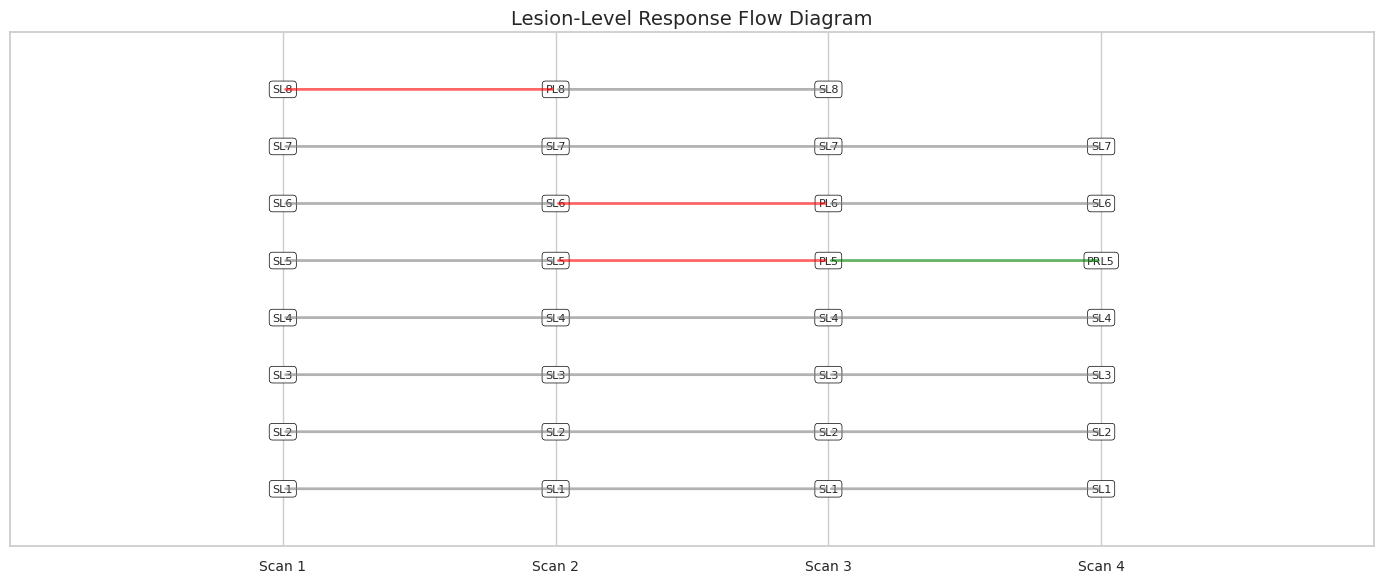

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re

# === Load your CSV ===
df = pd.read_csv("lesion_node_labels.csv")
df = df.sort_values(by=['LesionID', 'TimepointStr'])

# === Extract LesionIndex (e.g., from 'Lesion_(3)_#3.uint16') ===
pattern = re.compile(r"\((\d+)\)")
df['LesionIndex'] = df['LesionID'].apply(lambda x: int(pattern.search(x).group(1)))

# === Create Scan Index ===
df['Scan'] = df.groupby('LesionID').cumcount() + 1
df['ScanLabel'] = "Scan " + df['Scan'].astype(str)

# === Set x/y Positions for Layout ===
x_spacing = 3
lesion_y_map = {l: y for y, l in enumerate(sorted(df['LesionID'].unique()))}
df['x'] = df['Scan'] * x_spacing
df['y'] = df['LesionID'].map(lesion_y_map)

# === Build Edges Between Timepoints ===
edges = []
colors = []
for lesion, group in df.groupby("LesionID"):
    group = group.sort_values("Scan")
    for i in range(len(group) - 1):
        src = (group.iloc[i]['x'], group.iloc[i]['y'])
        tgt = (group.iloc[i+1]['x'], group.iloc[i+1]['y'])
        label = group.iloc[i+1]['ResponseCode']
        if label.startswith("CRL") or label.startswith("PRL"):
            color = "green"
        elif label.startswith("PL") or label.startswith("NL"):
            color = "red"
        else:
            color = "gray"
        edges.append((src, tgt))
        colors.append(color)

# === Plotting ===
fig, ax = plt.subplots(figsize=(14, 6))
G = nx.DiGraph()
G.add_edges_from(edges)

# Draw labels at each node
for i, row in df.iterrows():
    label = f"{row['ResponseCode']}{row['LesionIndex']}"
    ax.text(row['x'], row['y'], label,
            ha='center', va='center', fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

# Draw edges as colored arrows
for i, (src, tgt) in enumerate(edges):
    ax.annotate("",
                xy=tgt, xycoords='data',
                xytext=src, textcoords='data',
                arrowprops=dict(arrowstyle="-", color=colors[i], lw=2, alpha=0.6))

# Axis formatting
ax.set_xlim(0, df['x'].max() + x_spacing)
ax.set_ylim(-1, len(lesion_y_map))
ax.set_xticks(sorted(df['x'].unique()))
ax.set_xticklabels(sorted(df['ScanLabel'].unique()), fontsize=10)
ax.set_yticks([])
ax.set_title("Lesion-Level Response Flow Diagram", fontsize=14)
plt.tight_layout()
plt.show()



'final_lesion_response_python_plot.png'

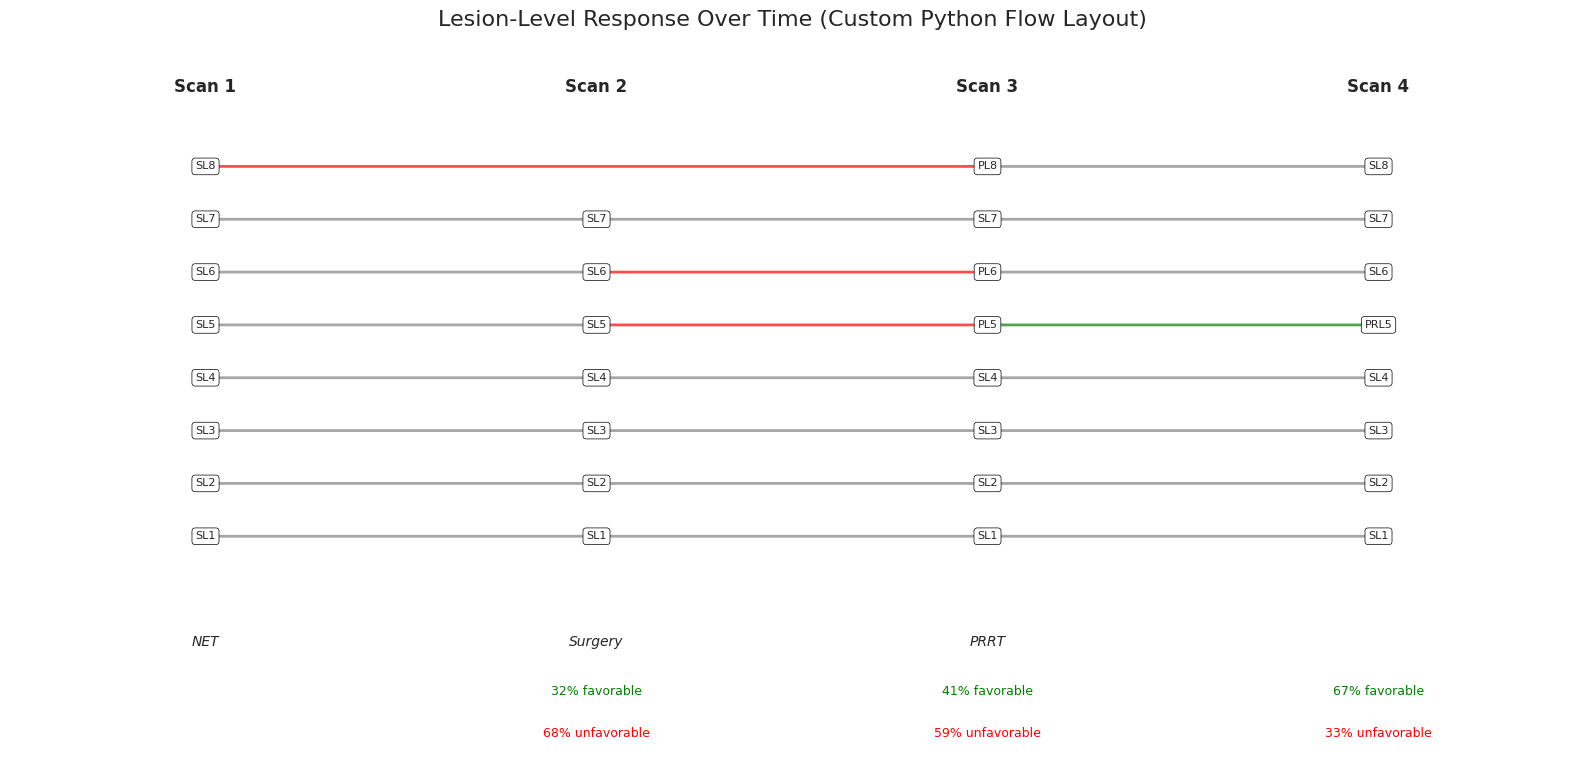

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import numpy as np
import re

# Load the CSV that was uploaded earlier
df = pd.read_csv("lesion_node_labels.csv")
df = df.sort_values(by=['LesionID', 'TimepointStr'])

# Extract lesion index from LesionID
pattern = re.compile(r"\((\d+)\)")
df['LesionIndex'] = df['LesionID'].apply(lambda x: int(pattern.search(x).group(1)))

# Assign scan index and scan labels
df['ScanIndex'] = df.groupby('LesionID').cumcount()
scan_order = sorted(df['TimepointStr'].unique())
scan_map = {s: i for i, s in enumerate(scan_order)}
df['ScanName'] = df['TimepointStr'].map(lambda x: f"Scan {scan_map[x]+1}")
df['ScanX'] = df['TimepointStr'].map(scan_map)

# Stack lesions vertically for each scan
df['Y'] = df.groupby(['ScanX'])['LesionID'].cumcount()

# Assign color based on response
def classify_response(label):
    if label.startswith("CRL") or label.startswith("PRL"):
        return "green"
    elif label.startswith("PL") or label.startswith("NL"):
        return "red"
    else:
        return "gray"

df['Color'] = df['ResponseCode'].apply(classify_response)

# Plotting
fig, ax = plt.subplots(figsize=(16, 8))

# Draw curved connections between scans
for lesion_id, group in df.groupby('LesionID'):
    group = group.sort_values('ScanX')
    for i in range(len(group) - 1):
        x0, y0 = group.iloc[i][['ScanX', 'Y']]
        x1, y1 = group.iloc[i+1][['ScanX', 'Y']]
        color = group.iloc[i+1]['Color']
        verts = [(x0, y0), ((x0 + x1)/2, y0), ((x0 + x1)/2, y1), (x1, y1)]
        codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
        path = Path(verts, codes)
        patch = PathPatch(path, facecolor='none', edgecolor=color, lw=2, alpha=0.7)
        ax.add_patch(patch)

# Draw node labels
for _, row in df.iterrows():
    label = f"{row['ResponseCode']}{row['LesionIndex']}"
    ax.text(row['ScanX'], row['Y'], label, ha='center', va='center', fontsize=8,
            bbox=dict(boxstyle="round", fc="white", ec="black", lw=0.5))

# Draw scan labels
for scan_x in sorted(df['ScanX'].unique()):
    ax.text(scan_x, df['Y'].max() + 1.5, f"Scan {scan_x + 1}", ha='center', va='center', fontsize=12, fontweight='bold')

# Optional: treatment event labels
event_labels = {
    0: "NET",
    1: "Surgery",
    2: "PRRT",
}
for x, label in event_labels.items():
    ax.text(x, -2, label, ha='center', va='center', fontsize=10, fontstyle='italic')

# Optional: percent stats
percent_stats = {
    1: (32, 68),
    2: (41, 59),
    3: (67, 33)
}
for x, (fav, unfav) in percent_stats.items():
    ax.text(x, -3, f"{fav}% favorable", ha='center', color='green', fontsize=9)
    ax.text(x, -3.8, f"{unfav}% unfavorable", ha='center', color='red', fontsize=9)

# Final formatting
ax.set_xlim(-0.5, df['ScanX'].max() + 0.5)
ax.set_ylim(-4.5, df['Y'].max() + 2.5)
ax.axis('off')
ax.set_title("Lesion-Level Response Over Time (Custom Python Flow Layout)", fontsize=16)
plt.tight_layout()

# Save figure
output_path = "final_lesion_response_python_plot.png"
plt.savefig(output_path, dpi=300)
output_path


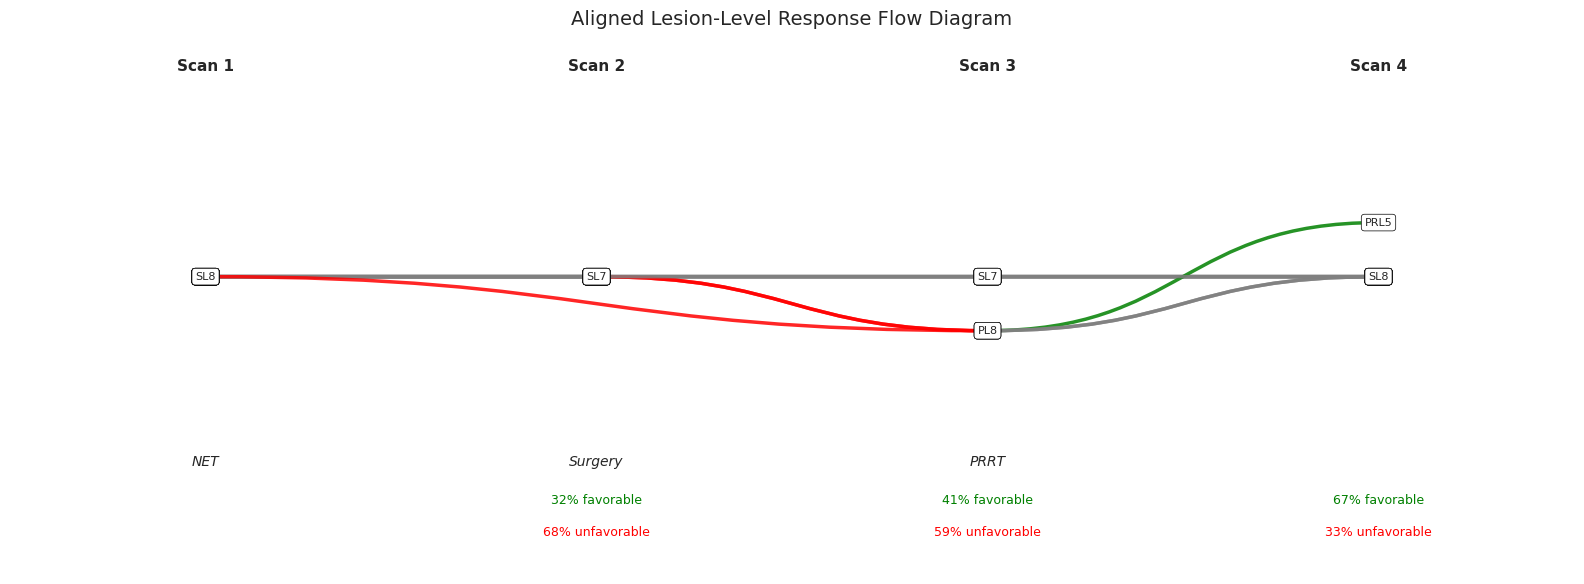

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import re

# === Load your data ===
df = pd.read_csv("lesion_node_labels.csv")  # ← replace with your actual path

# === Extract lesion index from LesionID (e.g., Lesion_(3)_#3.uint16 → 3) ===
df['LesionIndex'] = df['LesionID'].apply(lambda x: int(re.search(r"\((\d+)\)", x).group(1)))

# === Assign scan index (X position) ===
scan_order = sorted(df['TimepointStr'].unique())
scan_map = {s: i for i, s in enumerate(scan_order)}
df['ScanX'] = df['TimepointStr'].map(scan_map)

# === Assign vertical position based on response class ===
response_order = ["CRL", "PRL", "SL", "PL", "NL"]
response_y_map = {resp: i for i, resp in enumerate(response_order[::-1])}
df['Y_fixed'] = df['ResponseCode'].map(lambda x: response_y_map.get(x, -1))

# === Assign color for flow lines ===
def classify_color(label):
    if label.startswith("CRL") or label.startswith("PRL"):
        return "green"
    elif label.startswith("PL") or label.startswith("NL"):
        return "red"
    else:
        return "gray"
df['Color'] = df['ResponseCode'].apply(classify_color)

# === Plot starts here ===
fig, ax = plt.subplots(figsize=(16, 6))

# Draw curved connections (for each lesion through time)
for lesion_id, group in df.groupby('LesionID'):
    group = group.sort_values('ScanX')
    for i in range(len(group) - 1):
        x0, y0 = group.iloc[i][['ScanX', 'Y_fixed']]
        x1, y1 = group.iloc[i + 1][['ScanX', 'Y_fixed']]
        color = group.iloc[i + 1]['Color']
        verts = [(x0, y0), ((x0 + x1) / 2, y0), ((x0 + x1) / 2, y1), (x1, y1)]
        codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
        path = Path(verts, codes)
        patch = PathPatch(path, facecolor='none', edgecolor=color, lw=2.5, alpha=0.85)
        ax.add_patch(patch)

# Draw node labels
for _, row in df.iterrows():
    label = f"{row['ResponseCode']}{row['LesionIndex']}"
    ax.text(row['ScanX'], row['Y_fixed'], label, ha='center', va='center', fontsize=8,
            bbox=dict(boxstyle="round", fc="white", ec="black", lw=0.5))

# Add scan and treatment labels
for scan_x in sorted(df['ScanX'].unique()):
    ax.text(scan_x, len(response_order) + 0.8, f"Scan {scan_x + 1}", ha='center', fontsize=11, fontweight='bold')

event_labels = {0: "NET", 1: "Surgery", 2: "PRRT"}
for x, label in event_labels.items():
    ax.text(x, -1.5, label, ha='center', fontsize=10, fontstyle='italic')

# Add summary stats (example values, can be updated)
percent_stats = {1: (32, 68), 2: (41, 59), 3: (67, 33)}
for x, (fav, unfav) in percent_stats.items():
    ax.text(x, -2.2, f"{fav}% favorable", ha='center', color='green', fontsize=9)
    ax.text(x, -2.8, f"{unfav}% unfavorable", ha='center', color='red', fontsize=9)

# Final formatting
ax.set_xlim(-0.5, df['ScanX'].max() + 0.5)
ax.set_ylim(-3.5, len(response_order) + 1.5)
ax.axis('off')
ax.set_title("Aligned Lesion-Level Response Flow Diagram", fontsize=14)
plt.tight_layout()
plt.savefig("aligned_lesion_response_plot.png", dpi=300)
plt.show()


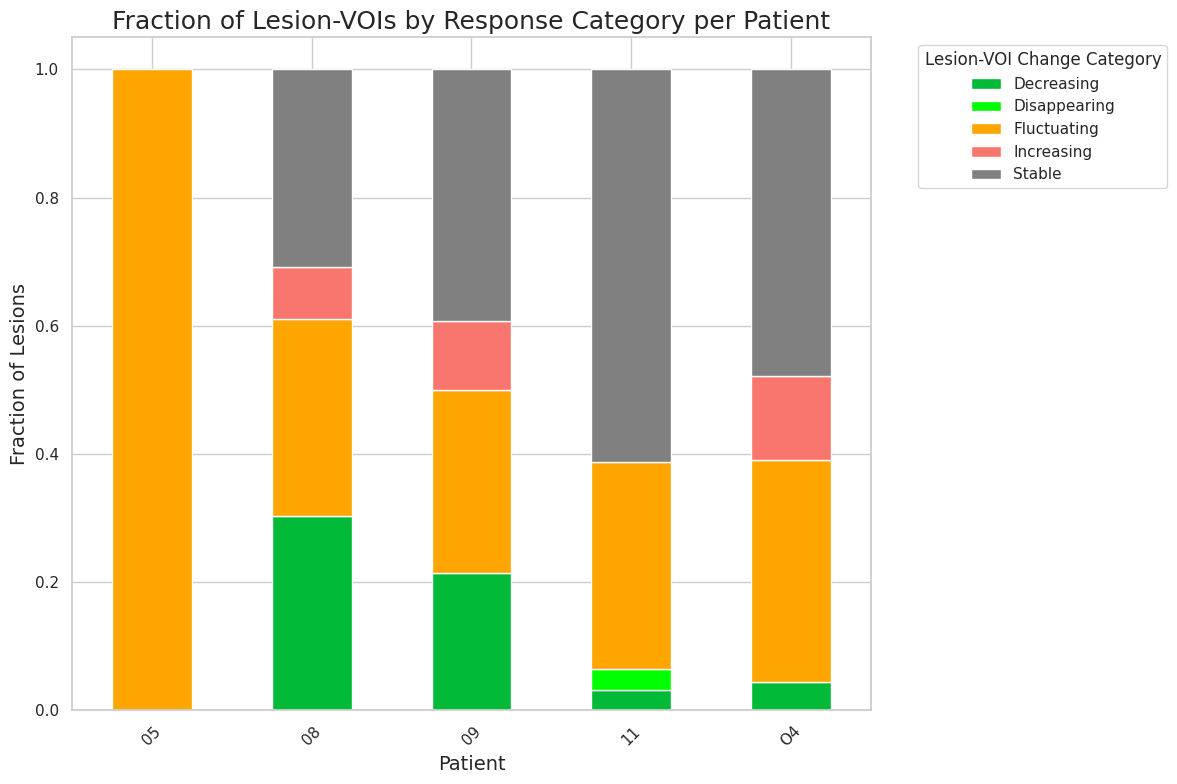

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os

# === Settings ===
DATA_DIR = "Lesion_volumes/"  # directory with CSV files
PATTERN = re.compile(r"\((\d+)\)")
COLOR_MAP = {
    'New': 'red',
    'Increasing': '#f8766d',
    'Stable': 'gray',
    'Decreasing': '#00ba38',
    'Disappearing': '#00ff00',
    'Fluctuating': 'orange'
}

# === Collect and concatenate all lesion_volumes_*.csv files ===
all_files = glob.glob(os.path.join(DATA_DIR, "lesion_volumes_*.csv"))
df_list = []
for file in all_files:
    # Extract PatientID from filename (customize as needed)
    base = os.path.basename(file)
    patient_id = base.replace("lesion_volumes_", "").replace(".csv", "")
    temp_df = pd.read_csv(file)
    temp_df['PatientID'] = patient_id
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)
df['Timepoint'] = pd.to_datetime(df['Timepoint'])

# === Lesion Label Extraction ===
def get_lesion_label(x):
    match = PATTERN.search(str(x))
    return f"Lesion {match.group(1)}" if match else str(x)
df['LesionLabel'] = df['LesionID'].apply(get_lesion_label)

# === Sort and Compute Volume Change per Lesion per Patient ===
df = df.sort_values(by=['PatientID', 'LesionLabel', 'Timepoint'])
df['VolumeChange'] = df.groupby(['PatientID', 'LesionLabel'])['Volume_mm3'].pct_change()

# === Classify Lesion Response ===
def classify_response(change, volume):
    if pd.isna(change):
        return 'Baseline'
    elif volume == 0:
        return 'Disappearing'
    elif change >= 0.2:
        return 'Increasing'
    elif change <= -0.2:
        return 'Decreasing'
    elif -0.05 <= change <= 0.05:
        return 'Stable'
    else:
        return 'Fluctuating'

df['ResponseType'] = df.apply(lambda x: classify_response(x['VolumeChange'], x['Volume_mm3']), axis=1)

# === Filter Out Baseline (not relevant for stacked chart) ===
df_filtered = df[df['ResponseType'] != 'Baseline']

# === Count and Normalize by Patient ===
response_counts = df_filtered.groupby(['PatientID', 'ResponseType'])['LesionID'].count().unstack().fillna(0)
response_fractions = response_counts.div(response_counts.sum(axis=1), axis=0)

# === Plot Stacked Bar Plot ===
ax = response_fractions.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=[COLOR_MAP.get(col, 'gray') for col in response_fractions.columns]
)
plt.title("Fraction of Lesion-VOIs by Response Category per Patient", fontsize=18)
plt.ylabel("Fraction of Lesions", fontsize=14)
plt.xlabel("Patient", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Lesion-VOI Change Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("lesion_response_distribution_ALL.png", dpi=300)
plt.show()


define same colour/categories for sankey

In [ ]:
import pandas as pd
import re

# Load data
df = pd.read_csv("lesion_volumes_O4.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])
df['TimepointStr'] = df['Timepoint'].dt.strftime('%Y-%m-%d')

# Extract simplified lesion labels
pattern = re.compile(r"\((\d+)\)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(str(x)).group(1)}" if pattern.search(str(x)) else str(x))

# If only one patient, add PatientID manually (e.g., "08")
if 'PatientID' not in df.columns:
    df['PatientID'] = '08'

# Ensure scan order (assuming ScanLabel is like 'Scan 1', 'Scan 2', ...)
df = df.sort_values(['PatientID', 'LesionLabel', 'Timepoint'])

# Compute percent change and category
df['VolumeChange'] = df.groupby(['PatientID', 'LesionLabel'])['Volume_mm3'].pct_change()
# After sorting by LesionLabel and Timepoint
df = df.sort_values(['PatientID', 'LesionLabel', 'Timepoint'])

# Assign ScanLabel by ordering unique timepoints per patient
df['ScanLabel'] = df.groupby('PatientID')['Timepoint'].rank(method='dense').astype(int)
df['ScanLabel'] = df['ScanLabel'].apply(lambda x: f"Scan {x}")

def classify_response(change, volume):
    if pd.isna(change):
        return 'Baseline'
    elif volume == 0:
        return 'Disappearing'
    elif change >= 0.2:
        return 'Increasing'
    elif change <= -0.2:
        return 'Decreasing'
    elif -0.05 <= change <= 0.05:
        return 'Stable'
    else:
        return 'Fluctuating'

df['ResponseType'] = df.apply(lambda x: classify_response(x['VolumeChange'], x['Volume_mm3']), axis=1)

# Pivot to wide form for Sankey plotting
pivot = df.pivot(index='LesionLabel', columns='ScanLabel', values='ResponseType')
pivot = pivot.sort_index(axis=1)  # scans in order
pivot.reset_index(inplace=True)
pivot.to_csv('patient_lesion_categories.csv', index=False)



In [ ]:
import plotly.graph_objects as go

scans = pivot.columns.tolist()

labels = []
label_indices = {}
for i, scan in enumerate(scans):
    for cat in ['Disappearing', 'Increasing', 'Decreasing', 'Stable', 'Fluctuating']:
        lbl = f"{cat}_{scan}"
        if lbl not in label_indices:
            label_indices[lbl] = len(labels)
            labels.append(lbl)

source, target, value, color = [], [], [], []

cat_colors = {
    'Decreasing': 'green',
    'Disappearing': 'lime',
    'Fluctuating': 'orange',
    'Increasing': 'red',
    'Stable': 'gray'
}

for i in range(len(scans)-1):
    s1, s2 = scans[i], scans[i+1]
    for cat_from in ['Disappearing', 'Increasing', 'Decreasing', 'Stable', 'Fluctuating']:
        for cat_to in ['Disappearing', 'Increasing', 'Decreasing', 'Stable', 'Fluctuating']:
            count = ((pivot[s1] == cat_from) & (pivot[s2] == cat_to)).sum()
            if count > 0:
                source.append(label_indices[f"{cat_from}_{s1}"])
                target.append(label_indices[f"{cat_to}_{s2}"])
                value.append(count)
                color.append(cat_colors[cat_from])

# Plot Sankey
fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=color
    )
))

fig.update_layout(title_text="Lesion Response Sankey for Patient 04", font_size=14)
fig.show()


changing the colormap

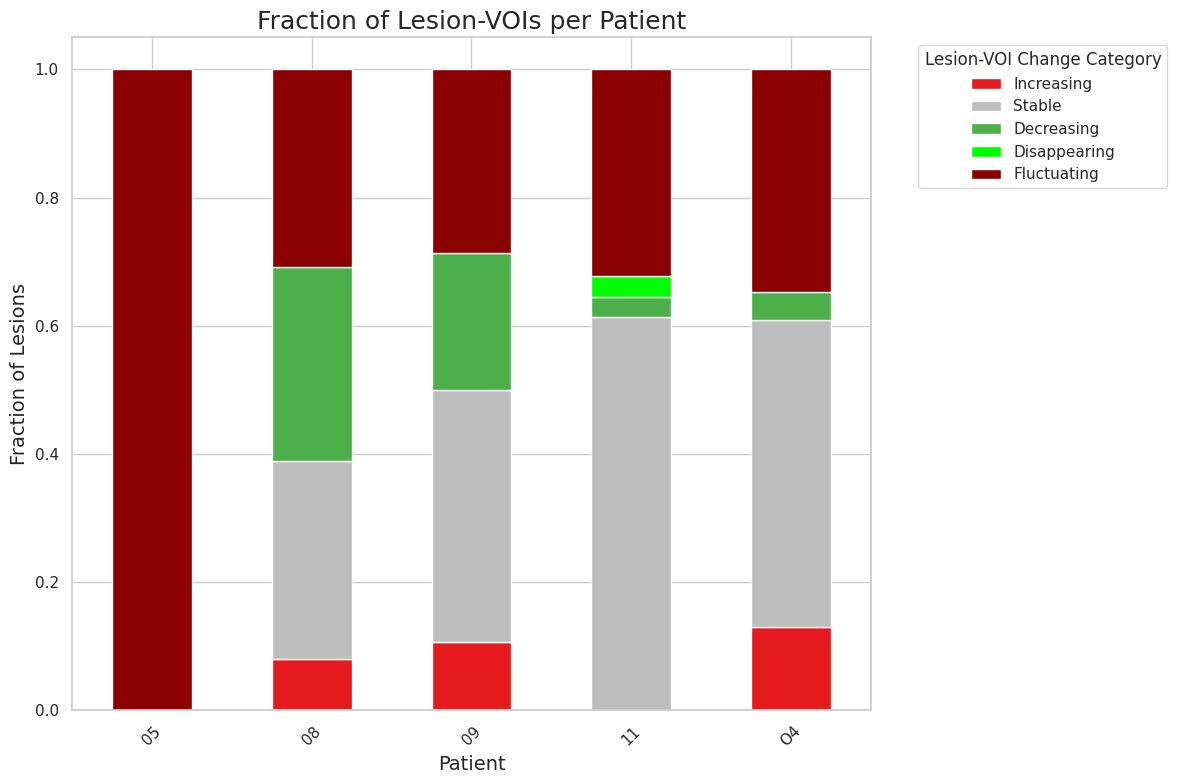

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os

# === Settings ===
DATA_DIR = "Lesion_volumes/"  # directory with CSV files
PATTERN = re.compile(r"\((\d+)\)")
COLOR_MAP = {
    'New': '#d62728',           # strong red
    'Increasing': '#e41a1c',    # vivid red
    'Stable': '#bdbdbd',        # light grey
    'Decreasing': '#4daf4a',    # green
    'Disappearing': '#00ff00',  # neon green
    'Fluctuating': '#8B0000'    # dark red
}


# === Collect and concatenate all lesion_volumes_*.csv files ===
all_files = glob.glob(os.path.join(DATA_DIR, "lesion_volumes_*.csv"))
if not all_files:
    raise ValueError(f"No files found in {DATA_DIR}")

df_list = []
for file in all_files:
    # Extract PatientID from filename (customize as needed)
    base = os.path.basename(file)
    patient_id = base.replace("lesion_volumes_", "").replace(".csv", "")
    temp_df = pd.read_csv(file)
    temp_df['PatientID'] = patient_id
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)
df['Timepoint'] = pd.to_datetime(df['Timepoint'])

# === Lesion Label Extraction ===
def get_lesion_label(x):
    match = PATTERN.search(str(x))
    return f"Lesion {match.group(1)}" if match else str(x)
df['LesionLabel'] = df['LesionID'].apply(get_lesion_label)

# === Sort and Compute Volume Change per Lesion per Patient ===
df = df.sort_values(by=['PatientID', 'LesionLabel', 'Timepoint'])
df['VolumeChange'] = df.groupby(['PatientID', 'LesionLabel'])['Volume_mm3'].pct_change()

# === Classify Lesion Response ===
def classify_response(change, volume):
    if pd.isna(change):
        return 'Baseline'
    elif volume == 0:
        return 'Disappearing'
    elif change >= 0.2:
        return 'Increasing'
    elif change <= -0.2:
        return 'Decreasing'
    elif -0.05 <= change <= 0.05:
        return 'Stable'
    else:
        return 'Fluctuating'

df['ResponseType'] = df.apply(lambda x: classify_response(x['VolumeChange'], x['Volume_mm3']), axis=1)

# === Filter Out Baseline (not relevant for stacked chart) ===
df_filtered = df[df['ResponseType'] != 'Baseline']

# === Count and Normalize by Patient ===
response_counts = df_filtered.groupby(['PatientID', 'ResponseType'])['LesionID'].count().unstack().fillna(0)

# === Determine adaptive column order: Use only categories present, match a preferred plot order if possible ===
preferred_order = ['New', 'Increasing', 'Stable', 'Decreasing', 'Disappearing', 'Fluctuating']
present_order = [cat for cat in preferred_order if cat in response_counts.columns]
# If some unexpected types are present, add them at the end
remaining = [cat for cat in response_counts.columns if cat not in preferred_order]
final_order = present_order + remaining

response_fractions = response_counts[final_order].div(response_counts.sum(axis=1), axis=0)

# === Adaptive color list ===
colors = [COLOR_MAP.get(col, 'gray') for col in final_order]

# === Plot Stacked Bar Plot ===
ax = response_fractions.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=colors
)
plt.title("Fraction of Lesion-VOIs per Patient", fontsize=18)
plt.ylabel("Fraction of Lesions", fontsize=14)
plt.xlabel("Patient", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Lesion-VOI Change Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("lesion_response_distribution_ALL.png", dpi=300)
plt.show()



In [ ]:
import pandas as pd
import re

# Load data
df = pd.read_csv("lesion_volumes_09.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])
df['TimepointStr'] = df['Timepoint'].dt.strftime('%Y-%m-%d')

# Extract simplified lesion labels
pattern = re.compile(r"\((\d+)\)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(str(x)).group(1)}" if pattern.search(str(x)) else str(x))

# If only one patient, add PatientID manually (e.g., "08")
if 'PatientID' not in df.columns:
    df['PatientID'] = '08'

# Ensure scan order (assuming ScanLabel is like 'Scan 1', 'Scan 2', ...)
df = df.sort_values(['PatientID', 'LesionLabel', 'Timepoint'])

# Compute percent change and category
df['VolumeChange'] = df.groupby(['PatientID', 'LesionLabel'])['Volume_mm3'].pct_change()
# After sorting by LesionLabel and Timepoint
df = df.sort_values(['PatientID', 'LesionLabel', 'Timepoint'])

# Assign ScanLabel by ordering unique timepoints per patient
df['ScanLabel'] = df.groupby('PatientID')['Timepoint'].rank(method='dense').astype(int)
df['ScanLabel'] = df['ScanLabel'].apply(lambda x: f"Scan {x}")

def classify_response(change, volume):
    if pd.isna(change):
        return 'Baseline'
    elif volume == 0:
        return 'Disappearing'
    elif change >= 0.2:
        return 'Increasing'
    elif change <= -0.2:
        return 'Decreasing'
    elif -0.05 <= change <= 0.05:
        return 'Stable'
    else:
        return 'Fluctuating'

df['ResponseType'] = df.apply(lambda x: classify_response(x['VolumeChange'], x['Volume_mm3']), axis=1)

# Pivot to wide form for Sankey plotting
pivot = df.pivot(index='LesionLabel', columns='ScanLabel', values='ResponseType')
pivot = pivot.sort_index(axis=1)  # scans in order
pivot.reset_index(inplace=True)
pivot.to_csv('patient_lesion_categories.csv', index=False)

In [ ]:
import plotly.graph_objects as go

scans = pivot.columns.tolist()

labels = []
label_indices = {}
for i, scan in enumerate(scans):
    for cat in ['Disappearing', 'Increasing', 'Decreasing', 'Stable', 'Fluctuating']:
        lbl = f"{cat}_{scan}"
        if lbl not in label_indices:
            label_indices[lbl] = len(labels)
            labels.append(lbl)

source, target, value, color = [], [], [], []

cat_colors =  {
    'New': '#d62728',           # strong red
    'Increasing': '#e41a1c',    # vivid red
    'Stable': '#bdbdbd',        # light grey
    'Decreasing': '#4daf4a',    # green
    'Disappearing': '#00ff00',  # neon green
    'Fluctuating': '#8B0000'    # dark red
}


for i in range(len(scans)-1):
    s1, s2 = scans[i], scans[i+1]
    for cat_from in ['Disappearing', 'Increasing', 'Decreasing', 'Stable', 'Fluctuating']:
        for cat_to in ['Disappearing', 'Increasing', 'Decreasing', 'Stable', 'Fluctuating']:
            count = ((pivot[s1] == cat_from) & (pivot[s2] == cat_to)).sum()
            if count > 0:
                source.append(label_indices[f"{cat_from}_{s1}"])
                target.append(label_indices[f"{cat_to}_{s2}"])
                value.append(count)
                color.append(cat_colors[cat_from])

# Plot Sankey
fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=color
    )
))

fig.update_layout(title_text="Lesion Volume changes Sankey", font_size=14)
fig.show()


In [ ]:
print(sorted(df['ScanLabel'].unique()))


['Scan 1', 'Scan 2', 'Scan 3']


In [ ]:
# After your existing pivot
scan_labels = sorted(df['ScanLabel'].unique(), key=lambda x: int(re.findall(r'\d+', x)[0]))
pivot = df.pivot(index='LesionLabel', columns='ScanLabel', values='ResponseType')
pivot = pivot.reindex(columns=scan_labels)   # Ensures all scans are present, even if NaN for some
pivot.reset_index(inplace=True)


In [ ]:
category_list = ['New', 'Increasing', 'Stable', 'Decreasing', 'Disappearing', 'Fluctuating']
# ... or whatever you use


In [ ]:
import pandas as pd
import re
import plotly.graph_objects as go

df = pd.read_csv("lesion_volumes_09.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])
pattern = re.compile(r"\((\d+)\)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(str(x)).group(1)}" if pattern.search(str(x)) else str(x))

if 'PatientID' not in df.columns:
    df['PatientID'] = '09'

df = df.sort_values(['PatientID', 'LesionLabel', 'Timepoint'])
df['VolumeChange'] = df.groupby(['PatientID', 'LesionLabel'])['Volume_mm3'].pct_change()
df['ScanLabel'] = df.groupby('PatientID')['Timepoint'].rank(method='dense').astype(int)
df['ScanLabel'] = df['ScanLabel'].apply(lambda x: f"Scan {x}")

def classify_response(change, volume):
    if pd.isna(change):
        return 'Baseline'
    elif volume == 0:
        return 'Disappearing'
    elif change >= 0.2:
        return 'Increasing'
    elif change <= -0.2:
        return 'Decreasing'
    elif -0.05 <= change <= 0.05:
        return 'Stable'
    else:
        return 'Fluctuating'

df['ResponseType'] = df.apply(lambda x: classify_response(x['VolumeChange'], x['Volume_mm3']), axis=1)

# Make sure all scan columns are present
scan_labels = sorted(df['ScanLabel'].unique(), key=lambda x: int(re.findall(r'\d+', x)[0]))
labels = []
label_indices = {}
for scan in scan_labels:
    for cat in categories:
        lbl = f"{cat}_{scan}"
        if lbl not in label_indices:
            label_indices[lbl] = len(labels)
            labels.append(lbl)

pivot = df.pivot(index='LesionLabel', columns='ScanLabel', values='ResponseType')
pivot = pivot.reindex(columns=scan_labels)   # Ensures all scan columns
pivot.reset_index(inplace=True)

# Sankey
labels = []
label_indices = {}
for scan in scan_labels:
    for cat in ['New', 'Increasing', 'Stable', 'Decreasing', 'Disappearing', 'Fluctuating']:
        lbl = f"{cat}_{scan}"
        if lbl not in label_indices:
            label_indices[lbl] = len(labels)
            labels.append(lbl)

source, target, value, color = [], [], [], []

cat_colors =  {
    'Baseline': '#444444',      # dark gray (or use '#aaaaaa' for lighter gray)
    'New': '#d62728',
    'Increasing': '#e41a1c',
    'Stable': '#bdbdbd',
    'Decreasing': '#4daf4a',
    'Disappearing': '#00ff00',
    'Fluctuating': '#8B0000'
}
categories = list(cat_colors.keys())


for i in range(len(scan_labels) - 1):
    s1, s2 = scan_labels[i], scan_labels[i+1]
    for cat_from in cat_colors.keys():
        for cat_to in cat_colors.keys():
            count = ((pivot[s1] == cat_from) & (pivot[s2] == cat_to)).sum()
            if count > 0:
                source.append(label_indices[f"{cat_from}_{s1}"])
                target.append(label_indices[f"{cat_to}_{s2}"])
                value.append(count)
                color.append(cat_colors[cat_from])

fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=color
    )
))

fig.update_layout(title_text="Lesion Volume changes Sankey", font_size=14)
fig.show()


In [ ]:
import pandas as pd
import re
import plotly.graph_objects as go

df = pd.read_csv("lesion_volumes_09.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])
pattern = re.compile(r"\((\d+)\)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(str(x)).group(1)}" if pattern.search(str(x)) else str(x))

if 'PatientID' not in df.columns:
    df['PatientID'] = '09'

df = df.sort_values(['PatientID', 'LesionLabel', 'Timepoint'])
df['VolumeChange'] = df.groupby(['PatientID', 'LesionLabel'])['Volume_mm3'].pct_change()
df['ScanLabel'] = df.groupby('PatientID')['Timepoint'].rank(method='dense').astype(int)
df['ScanLabel'] = df['ScanLabel'].apply(lambda x: f"Scan {x}")

def classify_response(change, volume):
    if pd.isna(change):
        return 'Baseline'
    elif volume == 0:
        return 'Disappearing'
    elif change >= 0.2:
        return 'Increasing'
    elif change <= -0.2:
        return 'Decreasing'
    elif -0.05 <= change <= 0.05:
        return 'Stable'
    else:
        return 'Fluctuating'

df['ResponseType'] = df.apply(lambda x: classify_response(x['VolumeChange'], x['Volume_mm3']), axis=1)

scan_labels = sorted(df['ScanLabel'].unique(), key=lambda x: int(re.findall(r'\d+', x)[0]))
pivot = df.pivot(index='LesionLabel', columns='ScanLabel', values='ResponseType')
pivot = pivot.reindex(columns=scan_labels)
pivot.reset_index(inplace=True)

cat_colors =  {
    'Baseline': '#444444',      # dark gray
    'New': '#d62728',
    'Increasing': '#e41a1c',
    'Stable': '#bdbdbd',
    'Decreasing': '#4daf4a',
    'Disappearing': '#00ff00',
    'Fluctuating': '#8B0000'
}
categories = list(cat_colors.keys())

labels = []
label_indices = {}
for scan in scan_labels:
    for cat in categories:
        lbl = f"{cat}_{scan}"
        if lbl not in label_indices:
            label_indices[lbl] = len(labels)
            labels.append(lbl)

source, target, value, color = [], [], [], []

for i in range(len(scan_labels) - 1):
    s1, s2 = scan_labels[i], scan_labels[i+1]
    for cat_from in categories:
        for cat_to in categories:
            count = ((pivot[s1] == cat_from) & (pivot[s2] == cat_to)).sum()
            if count > 0:
                source.append(label_indices[f"{cat_from}_{s1}"])
                target.append(label_indices[f"{cat_to}_{s2}"])
                value.append(count)
                # HERE IS THE IMPORTANT CHANGE:
                color.append(cat_colors[cat_to])

fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=color
    )
))

fig.update_layout(title_text="Lesion Volume changes Sankey", font_size=14)
fig.show()


In [ ]:
import pandas as pd
import re
import plotly.graph_objects as go

# --- Data Preparation ---
df = pd.read_csv("lesion_volumes_09.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])
pattern = re.compile(r"\((\d+)\)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(str(x)).group(1)}" if pattern.search(str(x)) else str(x))

if 'PatientID' not in df.columns:
    df['PatientID'] = '09'

df = df.sort_values(['PatientID', 'LesionLabel', 'Timepoint'])
df['VolumeChange'] = df.groupby(['PatientID', 'LesionLabel'])['Volume_mm3'].pct_change()
df['ScanLabel'] = df.groupby('PatientID')['Timepoint'].rank(method='dense').astype(int)
df['ScanLabel'] = df['ScanLabel'].apply(lambda x: f"Scan {x}")

def classify_response(change, volume):
    if pd.isna(change):
        return 'Baseline'
    elif volume == 0:
        return 'Disappearing'
    elif change >= 0.2:
        return 'Increasing'
    elif change <= -0.2:
        return 'Decreasing'
    elif -0.05 <= change <= 0.05:
        return 'Stable'
    else:
        return 'Fluctuating'

df['ResponseType'] = df.apply(lambda x: classify_response(x['VolumeChange'], x['Volume_mm3']), axis=1)

scan_labels = sorted(df['ScanLabel'].unique(), key=lambda x: int(re.findall(r'\d+', x)[0]))
pivot = df.pivot(index='LesionLabel', columns='ScanLabel', values='ResponseType')
pivot = pivot.reindex(columns=scan_labels)
pivot.reset_index(inplace=True)

cat_colors =  {
    'Baseline': '#444444',      # dark gray
    'New': '#d62728',
    'Increasing': '#e41a1c',
    'Stable': '#bdbdbd',
    'Decreasing': '#4daf4a',
    'Disappearing': '#00ff00',
    'Fluctuating': '#8B0000'
}
categories = list(cat_colors.keys())

labels = []
label_indices = {}
for scan in scan_labels:
    for cat in categories:
        lbl = f"{cat}_{scan}"
        if lbl not in label_indices:
            label_indices[lbl] = len(labels)
            labels.append(lbl)

# --- Assign node color: each node colored by its category ---
node_colors = []
for lbl in labels:
    category = lbl.split('_')[0]
    node_colors.append(cat_colors.get(category, '#cccccc'))

source, target, value, color = [], [], [], []

for i in range(len(scan_labels) - 1):
    s1, s2 = scan_labels[i], scan_labels[i+1]
    for cat_from in categories:
        for cat_to in categories:
            count = ((pivot[s1] == cat_from) & (pivot[s2] == cat_to)).sum()
            if count > 0:
                source.append(label_indices[f"{cat_from}_{s1}"])
                target.append(label_indices[f"{cat_to}_{s2}"])
                value.append(count)
                # Color by the destination category
                color.append(cat_colors[cat_to])

fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors     # <-- Node color by category!
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=color
    )
))

fig.update_layout(title_text="Lesion Volume changes Sankey", font_size=14)
fig.show()


In [ ]:
import pandas as pd
import re
import plotly.graph_objects as go

# --- Data Preparation ---
df = pd.read_csv("lesion_volumes_09.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])
pattern = re.compile(r"\((\d+)\)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(str(x)).group(1)}" if pattern.search(str(x)) else str(x))

if 'PatientID' not in df.columns:
    df['PatientID'] = '09'

df = df.sort_values(['PatientID', 'LesionLabel', 'Timepoint'])
df['VolumeChange'] = df.groupby(['PatientID', 'LesionLabel'])['Volume_mm3'].pct_change()
df['ScanLabel'] = df.groupby('PatientID')['Timepoint'].rank(method='dense').astype(int)
df['ScanLabel'] = df['ScanLabel'].apply(lambda x: f"Scan {x}")

def classify_response(change, volume):
    if pd.isna(change):
        return 'Baseline'
    elif volume == 0:
        return 'Disappearing'
    elif change >= 0.2:
        return 'Increasing'
    elif change <= -0.2:
        return 'Decreasing'
    elif -0.05 <= change <= 0.05:
        return 'Stable'
    else:
        return 'Fluctuating'

df['ResponseType'] = df.apply(lambda x: classify_response(x['VolumeChange'], x['Volume_mm3']), axis=1)

scan_labels = sorted(df['ScanLabel'].unique(), key=lambda x: int(re.findall(r'\d+', x)[0]))
pivot = df.pivot(index='LesionLabel', columns='ScanLabel', values='ResponseType')
pivot = pivot.reindex(columns=scan_labels)
pivot.reset_index(inplace=True)

# --- Get categories present in your data for adaptive plotting ---
all_types = set(df['ResponseType'].unique())
# Make sure all possible categories have a color (add missing ones with a fallback if needed)
default_colors = {
    'Baseline': '#444444',      # dark gray
    'New': '#d62728',
    'Increasing': '#e41a1c',
    'Stable': '#bdbdbd',
    'Decreasing': '#4daf4a',
    'Disappearing': '#00ff00',
    'Fluctuating': '#8B0000'
}
cat_colors = {k: default_colors.get(k, '#cccccc') for k in all_types}
# Transparent version for links (alpha=0.4)
def hex_to_rgba(hex_color, alpha=0.4):
    hex_color = hex_color.lstrip('#')
    lv = len(hex_color)
    rgb = tuple(int(hex_color[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    return f'rgba({rgb[0]},{rgb[1]},{rgb[2]},{alpha})'

cat_colors_rgba = {k: hex_to_rgba(v) for k, v in cat_colors.items()}

categories = list(cat_colors.keys())

labels = []
label_indices = {}
for scan in scan_labels:
    for cat in categories:
        lbl = f"{cat}_{scan}"
        if lbl not in label_indices:
            label_indices[lbl] = len(labels)
            labels.append(lbl)

# --- Assign node color: each node colored by its category ---
node_colors = []
for lbl in labels:
    category = lbl.split('_')[0]
    node_colors.append(cat_colors.get(category, '#cccccc'))

source, target, value, color = [], [], [], []

for i in range(len(scan_labels) - 1):
    s1, s2 = scan_labels[i], scan_labels[i+1]
    for cat_from in categories:
        for cat_to in categories:
            count = ((pivot[s1] == cat_from) & (pivot[s2] == cat_to)).sum()
            if count > 0:
                source.append(label_indices[f"{cat_from}_{s1}"])
                target.append(label_indices[f"{cat_to}_{s2}"])
                value.append(count)
                # Color by the destination category (with transparency)
                color.append(cat_colors_rgba[cat_to])

fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors     # <-- Node color by category (solid)
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=color           # <-- Link color by category (transparent)
    )
))

fig.update_layout(title_text="Lesion Volume changes Sankey", font_size=14)
fig.show()


In [ ]:
import pandas as pd
import re
import plotly.graph_objects as go

# --- Data Preparation ---
df = pd.read_csv("lesion_volumes_09.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])
pattern = re.compile(r"\((\d+)\)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(str(x)).group(1)}" if pattern.search(str(x)) else str(x))

if 'PatientID' not in df.columns:
    df['PatientID'] = '09'

df = df.sort_values(['PatientID', 'LesionLabel', 'Timepoint'])
df['VolumeChange'] = df.groupby(['PatientID', 'LesionLabel'])['Volume_mm3'].pct_change()
df['ScanLabel'] = df.groupby('PatientID')['Timepoint'].rank(method='dense').astype(int)
df['ScanLabel'] = df['ScanLabel'].apply(lambda x: f"Scan {x}")

def classify_response(change, volume):
    if pd.isna(change):
        return 'Baseline'
    elif volume == 0:
        return 'Disappearing'
    elif change >= 0.2:
        return 'Increasing'
    elif change <= -0.2:
        return 'Decreasing'
    elif -0.05 <= change <= 0.05:
        return 'Stable'
    else:
        return 'Fluctuating'

df['ResponseType'] = df.apply(lambda x: classify_response(x['VolumeChange'], x['Volume_mm3']), axis=1)

scan_labels = sorted(df['ScanLabel'].unique(), key=lambda x: int(re.findall(r'\d+', x)[0]))
pivot = df.pivot(index='LesionLabel', columns='ScanLabel', values='ResponseType')
pivot = pivot.reindex(columns=scan_labels)
pivot.reset_index(inplace=True)

# --- Only create nodes that exist in data ---
existing_nodes = set()
for scan in scan_labels:
    for cat in df[df['ScanLabel'] == scan]['ResponseType'].unique():
        existing_nodes.add(f"{cat}_{scan}")

labels = list(existing_nodes)
label_indices = {lbl: i for i, lbl in enumerate(labels)}

# --- Assign node color: each node colored by its category ---
cat_colors =  {
    'Baseline': '#444444',      # dark gray
    'New': '#d62728',
    'Increasing': '#e41a1c',
    'Stable': '#bdbdbd',
    'Decreasing': '#4daf4a',
    'Disappearing': '#00ff00',
    'Fluctuating': '#8B0000'
}
def hex_to_rgba(hex_color, alpha=0.4):
    hex_color = hex_color.lstrip('#')
    lv = len(hex_color)
    rgb = tuple(int(hex_color[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    return f'rgba({rgb[0]},{rgb[1]},{rgb[2]},{alpha})'

node_colors = []
for lbl in labels:
    category = lbl.split('_')[0]
    node_colors.append(cat_colors.get(category, '#cccccc'))

# --- Flows (links) ---
source, target, value, color = [], [], [], []
cat_rgba = {k: hex_to_rgba(v) for k, v in cat_colors.items()}

for i in range(len(scan_labels) - 1):
    s1, s2 = scan_labels[i], scan_labels[i+1]
    for row in pivot.itertuples():
        cat_from = getattr(row, s1)
        cat_to = getattr(row, s2)
        if (f"{cat_from}_{s1}" in label_indices) and (f"{cat_to}_{s2}" in label_indices):
            source.append(label_indices[f"{cat_from}_{s1}"])
            target.append(label_indices[f"{cat_to}_{s2}"])
            value.append(1)
            color.append(cat_rgba.get(cat_to, 'rgba(180,180,180,0.4)'))

# --- Sankey Diagram ---
fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=color
    )
))

# --- Add scan header annotations above each group ---
scan_indices = {scan: [] for scan in scan_labels}
for idx, lbl in enumerate(labels):
    scan = "_".join(lbl.split('_')[1:])
    scan_indices[scan].append(idx)

node_x = []
node_y = []
# Estimate node x positions (evenly spaced per scan)
x_positions = {}
n_scans = len(scan_labels)
for i, scan in enumerate(scan_labels):
    x_positions[scan] = i / (n_scans - 1) if n_scans > 1 else 0.5

annotations = []
for i, scan in enumerate(scan_labels):
    x = x_positions[scan]
    annotations.append(dict(
        x=x,
        y=1.08,   # just above the diagram
        xref='paper',
        yref='paper',
        text=f'<b>{scan}</b>',
        showarrow=False,
        font=dict(size=18, color='black'),
        align='center'
    ))

fig.update_layout(
    title_text="Lesion Volume changes Sankey",
    font_size=14,
    annotations=annotations
)
fig.show()


AttributeError: 'Pandas' object has no attribute 'Scan 1'

In [ ]:
import pandas as pd
import re
import plotly.graph_objects as go

# --- Data Preparation ---
df = pd.read_csv("lesion_volumes_09.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])
pattern = re.compile(r"\((\d+)\)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(str(x)).group(1)}" if pattern.search(str(x)) else str(x))

if 'PatientID' not in df.columns:
    df['PatientID'] = '09'

df = df.sort_values(['PatientID', 'LesionLabel', 'Timepoint'])
df['VolumeChange'] = df.groupby(['PatientID', 'LesionLabel'])['Volume_mm3'].pct_change()
df['ScanLabel'] = df.groupby('PatientID')['Timepoint'].rank(method='dense').astype(int)
df['ScanLabel'] = df['ScanLabel'].apply(lambda x: f"Scan {x}")

def classify_response(change, volume):
    if pd.isna(change):
        return 'Baseline'
    elif volume == 0:
        return 'Disappearing'
    elif change >= 0.2:
        return 'Increasing'
    elif change <= -0.2:
        return 'Decreasing'
    elif -0.05 <= change <= 0.05:
        return 'Stable'
    else:
        return 'Fluctuating'

df['ResponseType'] = df.apply(lambda x: classify_response(x['VolumeChange'], x['Volume_mm3']), axis=1)

scan_labels = sorted(df['ScanLabel'].unique(), key=lambda x: int(re.findall(r'\d+', x)[0]))
pivot = df.pivot(index='LesionLabel', columns='ScanLabel', values='ResponseType')
pivot = pivot.reindex(columns=scan_labels)
pivot.reset_index(inplace=True)

# --- Build list of unique (category, scan) pairs in scan-column order and consistent category order ---
category_order = ['Baseline', 'Stable', 'Increasing', 'Decreasing', 'Disappearing', 'Fluctuating', 'New']
node_tuples = []
for scan in scan_labels:
    col_vals = pivot[scan].dropna().unique()
    # Use only categories present, but in preferred order for this scan
    for cat in category_order:
        if cat in col_vals:
            node_tuples.append((cat, scan))

labels = [f"{cat}_{scan}" for cat, scan in node_tuples]
label_indices = {lbl: i for i, lbl in enumerate(labels)}

cat_colors =  {
    'Baseline': '#444444',      # dark gray
    'New': '#d62728',
    'Increasing': '#e41a1c',
    'Stable': '#bdbdbd',
    'Decreasing': '#4daf4a',
    'Disappearing': '#00ff00',
    'Fluctuating': '#8B0000'
}
def hex_to_rgba(hex_color, alpha=0.4):
    hex_color = hex_color.lstrip('#')
    lv = len(hex_color)
    rgb = tuple(int(hex_color[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    return f'rgba({rgb[0]},{rgb[1]},{rgb[2]},{alpha})'

node_colors = []
for cat, scan in node_tuples:
    node_colors.append(cat_colors.get(cat, '#cccccc'))

# --- Build links ---
source, target, value, color = [], [], [], []
cat_rgba = {k: hex_to_rgba(v) for k, v in cat_colors.items()}

for row in pivot.itertuples(index=False):
    for i in range(len(scan_labels)-1):
        s1, s2 = scan_labels[i], scan_labels[i+1]
        cat_from = getattr(row, s1)
        cat_to = getattr(row, s2)
        from_lbl = f"{cat_from}_{s1}"
        to_lbl = f"{cat_to}_{s2}"
        if from_lbl in label_indices and to_lbl in label_indices:
            source.append(label_indices[from_lbl])
            target.append(label_indices[to_lbl])
            value.append(1)
            color.append(cat_rgba.get(cat_to, 'rgba(180,180,180,0.4)'))

# --- Sankey Diagram ---
fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=color
    )
))

# --- Add scan header annotations above each group ---
n_scans = len(scan_labels)
annotations = []
for i, scan in enumerate(scan_labels):
    x = i / (n_scans - 1) if n_scans > 1 else 0.5
    annotations.append(dict(
        x=x,
        y=1.08,   # just above the diagram
        xref='paper',
        yref='paper',
        text=f'<b>{scan}</b>',
        showarrow=False,
        font=dict(size=18, color='black'),
        align='center'
    ))

fig.update_layout(
    title_text="Lesion Volume changes Sankey",
    font_size=14,
    annotations=annotations
)
fig.show()



AttributeError: 'Pandas' object has no attribute 'Scan 1'

In [ ]:
import pandas as pd
import re
import plotly.graph_objects as go

# --- Data Preparation ---
df = pd.read_csv("lesion_volumes_O4.csv")
df['Timepoint'] = pd.to_datetime(df['Timepoint'])
pattern = re.compile(r"\((\d+)\)")
df['LesionLabel'] = df['LesionID'].apply(lambda x: f"Lesion {pattern.search(str(x)).group(1)}" if pattern.search(str(x)) else str(x))

if 'PatientID' not in df.columns:
    df['PatientID'] = '09'

df = df.sort_values(['PatientID', 'LesionLabel', 'Timepoint'])
df['VolumeChange'] = df.groupby(['PatientID', 'LesionLabel'])['Volume_mm3'].pct_change()
df['ScanLabel'] = df.groupby('PatientID')['Timepoint'].rank(method='dense').astype(int)
df['ScanLabel'] = df['ScanLabel'].apply(lambda x: f"Scan {x}")

def classify_response(change, volume):
    if pd.isna(change):
        return 'Baseline'
    elif volume == 0:
        return 'Disappearing'
    elif change >= 0.2:
        return 'Increasing'
    elif change <= -0.2:
        return 'Decreasing'
    elif -0.05 <= change <= 0.05:
        return 'Stable'
    else:
        return 'Fluctuating'

df['ResponseType'] = df.apply(lambda x: classify_response(x['VolumeChange'], x['Volume_mm3']), axis=1)

scan_labels = sorted(df['ScanLabel'].unique(), key=lambda x: int(re.findall(r'\d+', x)[0]))
pivot = df.pivot(index='LesionLabel', columns='ScanLabel', values='ResponseType')
pivot = pivot.reindex(columns=scan_labels)
pivot.reset_index(inplace=True)

# --- Build list of unique (category, scan) pairs in scan-column order and consistent category order ---
category_order = ['Baseline', 'Stable', 'Increasing', 'Decreasing', 'Disappearing', 'Fluctuating', 'New']
node_tuples = []
for scan in scan_labels:
    col_vals = pivot[scan].dropna().unique()
    for cat in category_order:
        if cat in col_vals:
            node_tuples.append((cat, scan))

labels = [f"{cat}_{scan}" for cat, scan in node_tuples]
label_indices = {lbl: i for i, lbl in enumerate(labels)}

cat_colors =  {
    'Baseline': '#444444',      # dark gray
    'New': '#d62728',
    'Increasing': '#e41a1c',
    'Stable': '#bdbdbd',
    'Decreasing': '#4daf4a',
    'Disappearing': '#00ff00',
    'Fluctuating': '#8B0000'
}
def hex_to_rgba(hex_color, alpha=0.4):
    hex_color = hex_color.lstrip('#')
    lv = len(hex_color)
    rgb = tuple(int(hex_color[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    return f'rgba({rgb[0]},{rgb[1]},{rgb[2]},{alpha})'

node_colors = []
for cat, scan in node_tuples:
    node_colors.append(cat_colors.get(cat, '#cccccc'))

# --- Build links using index-based column access ---
source, target, value, color = [], [], [], []
cat_rgba = {k: hex_to_rgba(v) for k, v in cat_colors.items()}

# Create mapping from scan label to index in the tuple (pivot)
scan_col_idx = {scan: idx+1 for idx, scan in enumerate(scan_labels)}  # +1 since first col is LesionLabel

for row in pivot.itertuples(index=False):
    for i in range(len(scan_labels)-1):
        s1, s2 = scan_labels[i], scan_labels[i+1]
        cat_from = row[scan_col_idx[s1]]
        cat_to = row[scan_col_idx[s2]]
        from_lbl = f"{cat_from}_{s1}"
        to_lbl = f"{cat_to}_{s2}"
        if from_lbl in label_indices and to_lbl in label_indices:
            source.append(label_indices[from_lbl])
            target.append(label_indices[to_lbl])
            value.append(1)
            color.append(cat_rgba.get(cat_to, 'rgba(180,180,180,0.4)'))

# --- Sankey Diagram ---
fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=color
    )
))

# --- Add scan header annotations above each group ---
n_scans = len(scan_labels)
annotations = []
for i, scan in enumerate(scan_labels):
    x = i / (n_scans - 1) if n_scans > 1 else 0.5
    annotations.append(dict(
        x=x,
        y=1.08,   # just above the diagram
        xref='paper',
        yref='paper',
        text=f'<b>{scan}</b>',
        showarrow=False,
        font=dict(size=18, color='black'),
        align='center'
    ))

fig.update_layout(
    title_text="PID=004",
    font_size=14,
    annotations=annotations
)
fig.show()


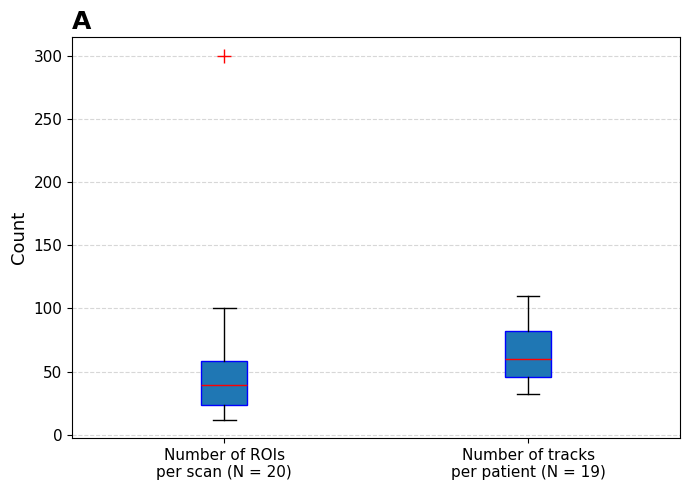

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dummy data example: Replace these with your real data!
num_rois_per_scan = [12, 20, 35, 22, 55, 41, 33, 48, 90, 20, 24, 15, 42, 30, 50, 38, 70, 100, 300, 75]  # example values
num_tracks_per_patient = [40, 50, 42, 65, 32, 51, 60, 47, 110, 90, 95, 85, 75, 80, 60, 55, 45, 39, 85]   # example values

data = [num_rois_per_scan, num_tracks_per_patient]
labels = [
    f"Number of ROIs\nper scan (N = {len(num_rois_per_scan)})",
    f"Number of tracks\nper patient (N = {len(num_tracks_per_patient)})"
]

plt.figure(figsize=(7, 5))
box = plt.boxplot(data, patch_artist=True, boxprops=dict(color='b'), medianprops=dict(color='red'), showfliers=True, flierprops=dict(marker='+', markerfacecolor='r', markersize=10, linestyle='none', markeredgecolor='r'))
plt.ylabel("Count", fontsize=13)
plt.xticks([1, 2], labels, fontsize=11)
plt.yticks(fontsize=11)
plt.title("A", loc='left', fontsize=18, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
